<font size=5><b>Game Analytics: D14 Retention Prediction</b></font>

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os

np.set_printoptions(formatter={'float': lambda x: "{0:0.4f}".format(x)})

In [2]:
# Import libraries: Machine Learning

from sklearn.preprocessing import OrdinalEncoder, StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold ## recommended for classification

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from scipy.stats import ks_2samp

from sklearn import tree

# Import Dataset & Data Quality Check

In [3]:
# Load training data
df = pd.read_csv('data/data_retention.csv', parse_dates = ["install_date"])
print(df.shape)

# Load test data
submitted_df = pd.read_csv('data/data_retention_submission.csv', parse_dates = ["install_date"])
print(submitted_df.shape)

(40000, 78)
(2296, 77)


## Basic Data Quality

In [4]:
df.tail(3)

,Player ID,AD_NETWORK,AD_CHANNEL,COUNTRY,CITY,LANGUAGE,DEVICE_BRAND,install_date,DX_TOTAL_SESSION_CT_0,DX_TOTAL_SESSION_CT_1,...,DX_START_ISIN_CHAPTER_1,DX_START_ISIN_CHAPTER_3,DX_START_ISIN_CHAPTER_7,DX_START_ISIN_CHAPTER_14,DX_END_ISIN_CHAPTER_0,DX_END_ISIN_CHAPTER_1,DX_END_ISIN_CHAPTER_3,DX_END_ISIN_CHAPTER_7,DX_END_ISIN_CHAPTER_14,retention_14
39997,Player39998,Ironsource,Paid,SE,Uddevalla,Swedish,google,2022-05-28,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
39998,Player39999,Unattributed,Paid,NL,Deurne,Dutch,Redmi,2022-03-26,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,False
39999,Player40000,Organic,Organic,NL,Gorinchem,Dutch,motorola,2022-07-30,3.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,False


In [5]:
submitted_df.tail(3)

,Player ID,AD_NETWORK,AD_CHANNEL,COUNTRY,CITY,LANGUAGE,DEVICE_BRAND,install_date,DX_TOTAL_SESSION_CT_0,DX_TOTAL_SESSION_CT_1,...,DX_START_ISIN_CHAPTER_0,DX_START_ISIN_CHAPTER_1,DX_START_ISIN_CHAPTER_3,DX_START_ISIN_CHAPTER_7,DX_START_ISIN_CHAPTER_14,DX_END_ISIN_CHAPTER_0,DX_END_ISIN_CHAPTER_1,DX_END_ISIN_CHAPTER_3,DX_END_ISIN_CHAPTER_7,DX_END_ISIN_CHAPTER_14
2293,Player42294,Unattributed,Paid,PH,Davao City,English,realme,2022-02-09,3.0,0.0,...,-1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0
2294,Player42295,Organic,Organic,PH,Quezon City,English,T-Mobile,2022-07-06,3.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2295,Player42296,Unattributed,Paid,PH,Quezon City,English,Redmi,2022-07-06,1.0,0.0,...,-1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0


In [6]:
df["retention_14"].mean()

0.053675

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
DX_TOTAL_SESSION_CT_0,40000.0,1.857250,1.833141,0.0,1.00,1.00,2.00,33.00
DX_TOTAL_SESSION_CT_1,40000.0,0.901875,2.470668,0.0,0.00,0.00,0.00,31.00
DX_TOTAL_SESSION_CT_3,40000.0,0.509500,1.932344,0.0,0.00,0.00,0.00,32.00
DX_TOTAL_SESSION_CT_7,40000.0,0.329000,1.543282,0.0,0.00,0.00,0.00,33.00
DX_TOTAL_PLAYTIME_0,40000.0,35.131672,91.104689,0.0,3.11,8.45,29.32,8638.85
...,...,...,...,...,...,...,...,...
DX_END_ISIN_CHAPTER_0,40000.0,0.066800,1.148617,-1.0,-1.00,0.00,1.00,5.00
DX_END_ISIN_CHAPTER_1,40000.0,0.365475,0.837061,-1.0,0.00,0.00,0.00,8.00
DX_END_ISIN_CHAPTER_3,40000.0,0.286825,0.876314,0.0,0.00,0.00,0.00,7.00
DX_END_ISIN_CHAPTER_7,40000.0,0.244125,0.900610,0.0,0.00,0.00,0.00,8.00


In [8]:
submitted_df.describe().T

,count,mean,std,min,25%,50%,75%,max
DX_TOTAL_SESSION_CT_0,2296.0,1.903310,1.897887,1.0,1.000,1.000,2.000,19.0
DX_TOTAL_SESSION_CT_1,2296.0,0.976916,2.604318,0.0,0.000,0.000,1.000,26.0
DX_TOTAL_SESSION_CT_3,2296.0,0.565331,2.029220,0.0,0.000,0.000,0.000,19.0
DX_TOTAL_SESSION_CT_7,2296.0,0.358885,1.627417,0.0,0.000,0.000,0.000,17.0
DX_TOTAL_PLAYTIME_0,2296.0,36.155828,79.066072,0.0,3.165,8.505,29.205,1108.2
...,...,...,...,...,...,...,...,...
DX_END_ISIN_CHAPTER_0,2296.0,0.089286,1.170572,-1.0,-1.000,0.000,1.000,5.0
DX_END_ISIN_CHAPTER_1,2296.0,0.387195,0.876412,0.0,0.000,0.000,0.000,5.0
DX_END_ISIN_CHAPTER_3,2296.0,0.311411,0.919491,0.0,0.000,0.000,0.000,5.0
DX_END_ISIN_CHAPTER_7,2296.0,0.254355,0.945453,0.0,0.000,0.000,0.000,6.0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 78 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   Player ID                        40000 non-null  object        
 1   AD_NETWORK                       39525 non-null  object        
 2   AD_CHANNEL                       40000 non-null  object        
 3   COUNTRY                          39998 non-null  object        
 4   CITY                             38344 non-null  object        
 5   LANGUAGE                         40000 non-null  object        
 6   DEVICE_BRAND                     40000 non-null  object        
 7   install_date                     40000 non-null  datetime64[ns]
 8   DX_TOTAL_SESSION_CT_0            40000 non-null  float64       
 9   DX_TOTAL_SESSION_CT_1            40000 non-null  float64       
 10  DX_TOTAL_SESSION_CT_3            40000 non-null  float64  

In [10]:
submitted_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2296 entries, 0 to 2295
Data columns (total 77 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   Player ID                        2296 non-null   object        
 1   AD_NETWORK                       2269 non-null   object        
 2   AD_CHANNEL                       2296 non-null   object        
 3   COUNTRY                          2296 non-null   object        
 4   CITY                             2215 non-null   object        
 5   LANGUAGE                         2296 non-null   object        
 6   DEVICE_BRAND                     2296 non-null   object        
 7   install_date                     2296 non-null   datetime64[ns]
 8   DX_TOTAL_SESSION_CT_0            2296 non-null   float64       
 9   DX_TOTAL_SESSION_CT_1            2296 non-null   float64       
 10  DX_TOTAL_SESSION_CT_3            2296 non-null   float64    

## Negative Value Check

In [11]:
df.describe().T[df.describe().T["min"] < 0]

,count,mean,std,min,25%,50%,75%,max
DX_START_ISIN_CHAPTER_0,40000.0,-0.060150,0.946311,-1.0,-1.0,0.0,1.0,4.0
DX_START_ISIN_CHAPTER_1,40000.0,0.291125,0.661046,-1.0,0.0,0.0,0.0,5.0
DX_END_ISIN_CHAPTER_0,40000.0,0.066800,1.148617,-1.0,-1.0,0.0,1.0,5.0
DX_END_ISIN_CHAPTER_1,40000.0,0.365475,0.837061,-1.0,0.0,0.0,0.0,8.0


In [12]:
submitted_df.describe().T[submitted_df.describe().T["min"] < 0]

,count,mean,std,min,25%,50%,75%,max
DX_START_ISIN_CHAPTER_0,2296.0,-0.051829,0.947151,-1.0,-1.0,0.0,1.0,1.0
DX_END_ISIN_CHAPTER_0,2296.0,0.089286,1.170572,-1.0,-1.0,0.0,1.0,5.0


In [13]:
# How many rows has -1 value
(df.iloc[:, 8:] < 0).any(axis=1).mean()

0.4793

In [14]:
# How many rows has -1 value
(submitted_df.iloc[:, 8:] < 0).any(axis=1).mean()

0.47560975609756095

## Missing Data Check

In [15]:
# How many NA
df.isna().sum()[df.isna().sum() > 0]

AD_NETWORK     475
COUNTRY          2
CITY          1656
dtype: int64

In [16]:
# How many NA
submitted_df.isna().sum()[submitted_df.isna().sum() > 0]

AD_NETWORK    27
CITY          81
dtype: int64

## Unique Value Check

In [17]:
# Compare how many unique between dataset
# I need to be careful if I were to use some kind of string Encoding. test_df may have something not in train_df.

pd.DataFrame({"df": df.iloc[:, :8].nunique(dropna = False),
              "submitted_df": submitted_df.iloc[:, :8].nunique(dropna = False)})

,df,submitted_df
Player ID,40000,2296
AD_NETWORK,9,8
AD_CHANNEL,3,3
COUNTRY,91,33
CITY,3011,600
LANGUAGE,53,31
DEVICE_BRAND,106,34
install_date,50,50


In [18]:
df["AD_NETWORK"].unique()

array(['Unattributed', 'Organic', 'Unity', 'Ironsource', nan, 'Adjoe',
       'Google Organic Search', 'Untrusted Devices', 'Liftoff'],
      dtype=object)

In [19]:
def print_unique(colname):
  print(colname + ": ")
  print(df[colname].unique())
  print(submitted_df[colname].unique(), end="\n\n")

# print_unique("reversal_ind")
print_unique("AD_NETWORK")
print_unique("AD_CHANNEL")
print_unique("COUNTRY")
print_unique("CITY")
print_unique("LANGUAGE")
print_unique("DEVICE_BRAND")

AD_NETWORK: 
['Unattributed' 'Organic' 'Unity' 'Ironsource' nan 'Adjoe'
 'Google Organic Search' 'Untrusted Devices' 'Liftoff']
['Organic' 'Adjoe' 'Unattributed' 'Unity' 'Ironsource' nan
 'Untrusted Devices' 'Google Organic Search']

AD_CHANNEL: 
['Paid' 'Organic' 'Unknown']
['Organic' 'Paid' 'Unknown']

COUNTRY: 
['SE' 'FI' 'AU' 'PH' 'SG' 'NO' 'NL' 'IQ' 'DK' 'MM' 'US' 'TH' 'IR' 'NZ'
 'IN' 'PT' 'MY' 'BD' 'FR' 'UG' 'DE' 'SY' 'QA' 'VU' 'RU' 'RO' 'PK' 'IL'
 'NG' 'UZ' 'HK' 'PL' 'FO' 'VN' 'SD' 'ES' 'UA' 'GB' 'HU' 'MA' 'TW' 'CZ'
 'JP' 'ZW' 'GR' 'OM' 'IT' 'CH' 'LT' 'MD' 'CN' 'AX' 'CA' 'TR' 'ID' 'AE'
 'LV' 'KR' nan 'KZ' 'RS' 'IS' 'CG' 'BG' 'DZ' 'LU' 'SA' 'EE' 'NP' 'AZ' 'AL'
 'CO' 'BE' 'BF' 'HT' 'BR' 'TN' 'MX' 'SO' 'BN' 'AT' 'EG' 'SN' 'BY' 'YE'
 'CY' 'KE' 'TT' 'ME' 'HR' 'AR']
['PH' 'NL' 'DK' 'SG' 'NO' 'AU' 'FI' 'SE' 'RO' 'ZW' 'BD' 'MY' 'PK' 'TR'
 'RU' 'DE' 'MM' 'US' 'IN' 'GB' 'NZ' 'TN' 'FR' 'IR' 'DZ' 'JP' 'NP' 'ES'
 'CA' 'HK' 'CN' 'BE' 'SD']

CITY: 
['Kristianstad' 'Helsinki' 'Perth' ... 'Bakhc

## Logic Check

In [20]:
# If "retention_14" == False then all the value must be 0 for D14
df[df["retention_14"] == False].iloc[:, df.columns.str.endswith('14')].max()

DX_TOTAL_PLAYTIME_14                 0.0
DX_TOTAL_SPEND_14                    0.0
DX_CAMPAIGN_MISSIONS_WON_14          0.0
DX_CAMPAIGN_MISSIONS_LOST_14         0.0
DX_CAMPAIGN_MISSIONS_RETREAT_14      0.0
DX_PVP_MATCHES_WON_14                0.0
DX_PVP_MATCHES_LOST_14               0.0
DX_PVP_MATCHES_RETREAT_14            0.0
DX_SIDE_MISSIONS_WON_14              0.0
DX_SIDE_MISSIONS_LOST_14             0.0
DX_SIDE_MISSIONS_RETREAT_14          0.0
DX_START_ISIN_CHAPTER_14             0.0
DX_END_ISIN_CHAPTER_14               0.0
retention_14                       False
dtype: object

In [21]:
# For some reason, There is one player with 0 total session on D0.
df.query("DX_TOTAL_SESSION_CT_0 == 0")

,Player ID,AD_NETWORK,AD_CHANNEL,COUNTRY,CITY,LANGUAGE,DEVICE_BRAND,install_date,DX_TOTAL_SESSION_CT_0,DX_TOTAL_SESSION_CT_1,...,DX_START_ISIN_CHAPTER_1,DX_START_ISIN_CHAPTER_3,DX_START_ISIN_CHAPTER_7,DX_START_ISIN_CHAPTER_14,DX_END_ISIN_CHAPTER_0,DX_END_ISIN_CHAPTER_1,DX_END_ISIN_CHAPTER_3,DX_END_ISIN_CHAPTER_7,DX_END_ISIN_CHAPTER_14,retention_14
31964,Player31965,Unity,Paid,NL,Amsterdam,Spanish,samsung,2022-07-26,0.0,1.0,...,-1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,False


In [22]:
# Chapter cannot go back a chapter within the same day
print(df[(df["DX_START_ISIN_CHAPTER_0"] > df["DX_END_ISIN_CHAPTER_0"])], end="\n\n")
print(df[(df["DX_START_ISIN_CHAPTER_1"] > df["DX_END_ISIN_CHAPTER_1"])], end="\n\n")
print(df[(df["DX_START_ISIN_CHAPTER_3"] > df["DX_END_ISIN_CHAPTER_3"])], end="\n\n")
print(df[(df["DX_START_ISIN_CHAPTER_7"] > df["DX_END_ISIN_CHAPTER_7"])], end="\n\n")
print(df[(df["DX_START_ISIN_CHAPTER_14"] > df["DX_END_ISIN_CHAPTER_14"])])

Empty DataFrame
Columns: [Player ID, AD_NETWORK, AD_CHANNEL, COUNTRY, CITY, LANGUAGE, DEVICE_BRAND, install_date, DX_TOTAL_SESSION_CT_0, DX_TOTAL_SESSION_CT_1, DX_TOTAL_SESSION_CT_3, DX_TOTAL_SESSION_CT_7, DX_TOTAL_PLAYTIME_0, DX_TOTAL_PLAYTIME_1, DX_TOTAL_PLAYTIME_3, DX_TOTAL_PLAYTIME_7, DX_TOTAL_PLAYTIME_14, DX_TOTAL_SPEND_0, DX_TOTAL_SPEND_1, DX_TOTAL_SPEND_3, DX_TOTAL_SPEND_7, DX_TOTAL_SPEND_14, DX_CAMPAIGN_MISSIONS_WON_0, DX_CAMPAIGN_MISSIONS_WON_1, DX_CAMPAIGN_MISSIONS_WON_3, DX_CAMPAIGN_MISSIONS_WON_7, DX_CAMPAIGN_MISSIONS_WON_14, DX_CAMPAIGN_MISSIONS_LOST_0, DX_CAMPAIGN_MISSIONS_LOST_1, DX_CAMPAIGN_MISSIONS_LOST_3, DX_CAMPAIGN_MISSIONS_LOST_7, DX_CAMPAIGN_MISSIONS_LOST_14, DX_CAMPAIGN_MISSIONS_RETREAT_0, DX_CAMPAIGN_MISSIONS_RETREAT_1, DX_CAMPAIGN_MISSIONS_RETREAT_3, DX_CAMPAIGN_MISSIONS_RETREAT_7, DX_CAMPAIGN_MISSIONS_RETREAT_14, DX_PVP_MATCHES_WON_0, DX_PVP_MATCHES_WON_1, DX_PVP_MATCHES_WON_3, DX_PVP_MATCHES_WON_7, DX_PVP_MATCHES_WON_14, DX_PVP_MATCHES_LOST_0, DX_PVP_MATCHES_

In [23]:
# How could they end D0 and start D1 with difference chapter?
# How could they go back to previous chapter?
df.query("DX_END_ISIN_CHAPTER_0 != 0 & DX_START_ISIN_CHAPTER_1 != 0 & DX_END_ISIN_CHAPTER_0 != DX_START_ISIN_CHAPTER_1").loc[:, ["DX_END_ISIN_CHAPTER_0", "DX_START_ISIN_CHAPTER_1"]]

,DX_END_ISIN_CHAPTER_0,DX_START_ISIN_CHAPTER_1
5918,5.0,4.0
6189,4.0,2.0
19074,4.0,3.0
20718,3.0,1.0
29503,2.0,1.0
39886,2.0,3.0


In [24]:
# The -1 seems to have some sort of special meaning.
# I will change it to zero. I have concerns with data leakage and I don't exactly know what -1 mean.
df.query("DX_END_ISIN_CHAPTER_0 in [0, -1]").groupby("DX_END_ISIN_CHAPTER_0").mean(numeric_only=True).T

DX_END_ISIN_CHAPTER_0,-1.0,0.0
DX_TOTAL_SESSION_CT_0,1.271400,1.644908
DX_TOTAL_SESSION_CT_1,0.000000,1.551166
DX_TOTAL_SESSION_CT_3,0.000000,0.657914
DX_TOTAL_SESSION_CT_7,0.000000,0.412761
DX_TOTAL_PLAYTIME_0,7.217464,30.360177
...,...,...
DX_END_ISIN_CHAPTER_1,0.000000,0.304540
DX_END_ISIN_CHAPTER_3,0.000000,0.219632
DX_END_ISIN_CHAPTER_7,0.000000,0.190184
DX_END_ISIN_CHAPTER_14,0.000000,0.158037


# Visualization

## Retention

Ideally, we should try to predict using only data from D0 as it was the time players quitted.

In [78]:
# I will consider a player still being retained if they play after DX but not on DX.
# This can only be done with historical data, so I will only use this data to illustrate the impact.
# Thus, I will not use this type of calculation for the prediction model as we don't know if players will come back after DX.

retention_graph = pd.DataFrame({"DX": [0, 1, 3, 7, 14], "Retention": [
    (df[["DX_TOTAL_SESSION_CT_0", "DX_TOTAL_SESSION_CT_1", "DX_TOTAL_SESSION_CT_3", "DX_TOTAL_SESSION_CT_7", "DX_TOTAL_PLAYTIME_14"]] > 0).any(axis=1).mean(),
     (df[["DX_TOTAL_SESSION_CT_1", "DX_TOTAL_SESSION_CT_3", "DX_TOTAL_SESSION_CT_7", "DX_TOTAL_PLAYTIME_14"]] > 0).any(axis=1).mean(),
      (df[["DX_TOTAL_SESSION_CT_3", "DX_TOTAL_SESSION_CT_7", "DX_TOTAL_PLAYTIME_14"]] > 0).any(axis=1).mean(),
       (df[["DX_TOTAL_SESSION_CT_7", "DX_TOTAL_PLAYTIME_14"]] > 0).any(axis=1).mean(),
        (df["DX_TOTAL_PLAYTIME_14"] > 0).mean()]})

#  Retention based on retained players last time
retention_graph["Retention_marginal"] = retention_graph["Retention"] / retention_graph["Retention"].shift(1).fillna(1)

retention_graph

,DX,Retention,Retention_marginal
0,0,1.000000,1.000000
1,1,0.289275,0.289275
2,3,0.158775,0.548872
3,7,0.099075,0.623996
4,14,0.052775,0.532677


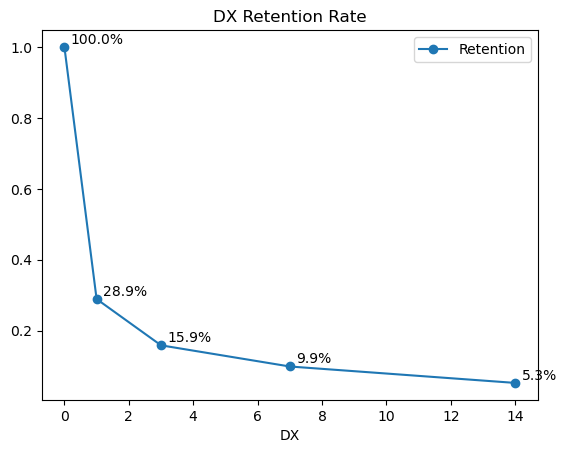

In [79]:
retention_graph.plot.line(x = "DX", y=["Retention"], marker ='o')

# Mark Label
for i, num in enumerate(retention_graph["Retention"]):
    plt.annotate("{:.1%}".format(num), (retention_graph["DX"][i]+0.2, num+0.01))

plt.title("DX Retention Rate")
plt.show()

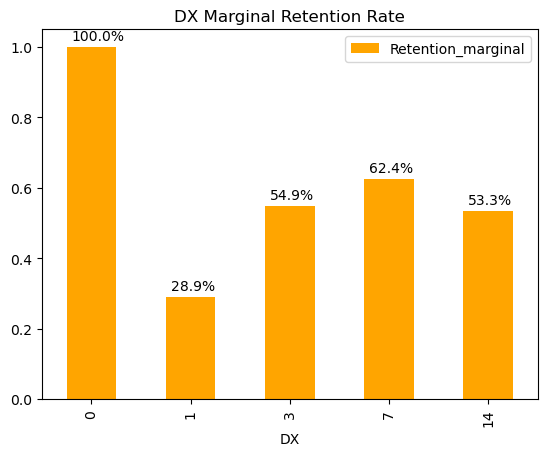

In [80]:
retention_graph.plot.bar(x = "DX", y=["Retention_marginal"], color="orange")

# Mark Label
for i, num in enumerate(retention_graph["Retention_marginal"]):
    plt.annotate("{:.1%}".format(num), (i-0.2, num+0.02))

plt.title("DX Marginal Retention Rate")
plt.show()

## Return Rate
I would love to see how many quit between D1-D13 and came back at D14.

In [28]:
comeback_graph = pd.DataFrame({"DX_quit": [1, 3, 7], "D14_return_percentage": [
     ((df["DX_TOTAL_SESSION_CT_1"] == 0) & (df["DX_TOTAL_PLAYTIME_14"] > 0)).mean() / (df["DX_TOTAL_SESSION_CT_1"] == 0).mean(),
      ((df["DX_TOTAL_SESSION_CT_3"] == 0) & (df["DX_TOTAL_PLAYTIME_14"] > 0)).mean() / (df["DX_TOTAL_SESSION_CT_3"] == 0).mean(),
       ((df["DX_TOTAL_SESSION_CT_7"] == 0) & (df["DX_TOTAL_PLAYTIME_14"] > 0)).mean() / (df["DX_TOTAL_SESSION_CT_7"] == 0).mean()]})

comeback_graph

,DX_quit,D14_return_percentage
0,1,0.012225
1,3,0.013185
2,7,0.012252


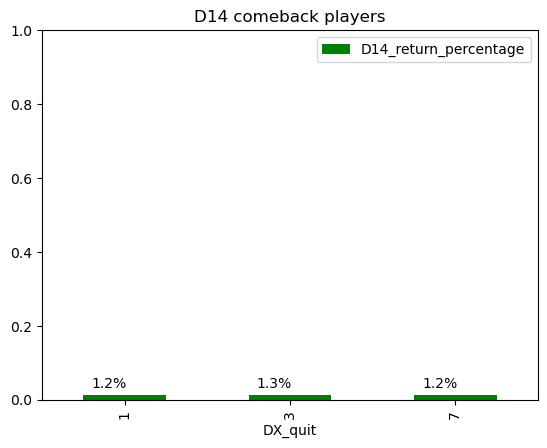

In [29]:
comeback_graph.plot.bar(x = "DX_quit", y=["D14_return_percentage"], color="green")

# Mark Label
for i, num in enumerate(comeback_graph["D14_return_percentage"]):
    plt.annotate("{:.1%}".format(num), (i-0.2, num+0.02))

plt.ylim(0, 1)

plt.title("D14 comeback players")
plt.show()

# Data Cleaning & Preparation

In [30]:
# Define features and target
X = df.drop(['retention_14'], axis=1).copy()
y = df['retention_14'].copy()

# I will stratefy train_test_split with all retention
stratefy_df = df[['retention_14']].copy()
stratefy_df["retention_1"] = (df["DX_TOTAL_SESSION_CT_1"] > 0).copy()
stratefy_df["retention_3"] = (df["DX_TOTAL_SESSION_CT_3"] > 0).copy()
stratefy_df["retention_7"] = (df["DX_TOTAL_SESSION_CT_7"] > 0).copy()

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = stratefy_df)

# for submission
X_submitted = submitted_df.copy()

## Missing Value

In [31]:
def fill_missing_categorical(categorical_col):

    # fill all with X_train mode
    mode = X_train[categorical_col].mode()[0]

    X_train[categorical_col] = X_train[categorical_col].fillna(mode)
    X_test[categorical_col] = X_test[categorical_col].fillna(mode)
    X_submitted[categorical_col] = X_submitted[categorical_col].fillna(mode)

    print("Fill nan with mode of {}: {}".format(categorical_col, mode), end="\n\n")
    print(X_train.groupby(categorical_col).size().sort_values(ascending=False))

In [32]:
fill_missing_categorical("AD_NETWORK")

Fill nan with mode of AD_NETWORK: Unattributed

AD_NETWORK
Unattributed             15367
Unity                     6001
Organic                   5186
Adjoe                     3219
Ironsource                2166
Google Organic Search       42
Untrusted Devices           17
Liftoff                      2
dtype: int64


In [33]:
# This doesn't make sense. Country is PH but city is Singapore. I will change it later.
fill_missing_categorical("COUNTRY")

Fill nan with mode of COUNTRY: PH

COUNTRY
PH    6664
NL    6076
SG    5423
AU    4273
SE    3452
      ... 
RS       1
IL       1
AR       1
MD       1
VU       1
Length: 81, dtype: int64


In [34]:
# This doesn't make sense. Country is PH but city is Singapore. I will change it later.
fill_missing_categorical("CITY")

Fill nan with mode of CITY: Singapore

CITY
Singapore      6223
Helsinki       1244
Sydney         1081
Melbourne       873
Amsterdam       870
               ... 
Genarp            1
Oldemarkt         1
Genemuiden        1
Oldeberkoop       1
Ørsta             1
Length: 2692, dtype: int64


## Fix unusual value

In [35]:
def start_end_negative_fix(X):

    for d in [0, 1, 3, 7, 14]:

        X["DX_START_ISIN_CHAPTER_" + str(d)] = X["DX_START_ISIN_CHAPTER_" + str(d)].apply(lambda chapter: np.max([chapter, 0]))
        X["DX_END_ISIN_CHAPTER_" + str(d)] = X["DX_END_ISIN_CHAPTER_" + str(d)].apply(lambda chapter: np.max([chapter, 0]))

        # # Should I drop this? Hmmmm
        # X.drop([won_name, lost_name, retreat_name], axis=1)

    return X.copy()

X_train = start_end_negative_fix(X_train)
X_test = start_end_negative_fix(X_test)
X_submitted = start_end_negative_fix(X_submitted)

# Feature Engineering

## Target Encoding: Categorical Variables
This has been used instead of OneHotEncoding specifically to reduce dimensionality.

In [36]:
def target_encoding(categorical_col):

    groupby_mean = y_train.groupby(X_train[categorical_col]).mean()
    overall_mean = y_train.mean()

    X_train[categorical_col + "_encoded"] = X_train[categorical_col].map(groupby_mean).fillna(overall_mean)
    X_test[categorical_col + "_encoded"] = X_test[categorical_col].map(groupby_mean).fillna(overall_mean)
    X_submitted[categorical_col + "_encoded"] = X_submitted[categorical_col].map(groupby_mean).fillna(overall_mean)

    print("Replace {} with the average retention_14 for each value.".format(categorical_col))
    print("If it is a new category, then replace it with overall mean of retention_14 at {}".format(str(overall_mean)), end="\n\n")
    print("The value are as follows:", end="\n\n")
    print(groupby_mean)

In [37]:
target_encoding("AD_NETWORK")

# Bosen: Player from Google might be higher.

Replace AD_NETWORK with the average retention_14 for each value.
If it is a new category, then replace it with overall mean of retention_14 at 0.0536875

The value are as follows:

AD_NETWORK
Adjoe                    0.129233
Google Organic Search    0.119048
Ironsource               0.041090
Liftoff                  0.000000
Organic                  0.067875
Unattributed             0.040281
Unity                    0.039327
Untrusted Devices        0.058824
Name: retention_14, dtype: float64


In [38]:
target_encoding("AD_CHANNEL")

Replace AD_CHANNEL with the average retention_14 for each value.
If it is a new category, then replace it with overall mean of retention_14 at 0.0536875

The value are as follows:

AD_CHANNEL
Organic    0.068286
Paid       0.051368
Unknown    0.013369
Name: retention_14, dtype: float64


In [39]:
# This depends on strategy? each country is different e.g. Korea vs China
X_train.groupby("COUNTRY").size().sort_values(ascending=False).head(20)

COUNTRY
PH    6664
NL    6076
SG    5423
AU    4273
SE    3452
DK    1985
FI    1778
NO    1263
MY     185
US     137
BD     102
MM      67
IN      61
IR      47
RU      44
DE      39
GB      38
ES      34
PK      29
FR      25
dtype: int64

In [40]:
target_encoding("COUNTRY")

Replace COUNTRY with the average retention_14 for each value.
If it is a new category, then replace it with overall mean of retention_14 at 0.0536875

The value are as follows:

COUNTRY
AE    0.000000
AR    0.000000
AT    0.000000
AU    0.052890
AX    0.000000
        ...   
UG    0.000000
US    0.007299
UZ    0.200000
VN    0.000000
VU    0.000000
Name: retention_14, Length: 81, dtype: float64


In [41]:
target_encoding("CITY")

Replace CITY with the average retention_14 for each value.
If it is a new category, then replace it with overall mean of retention_14 at 0.0536875

The value are as follows:

CITY
's-Gravendeel       0.000000
's-Gravenzande      0.000000
's-Heerenberg       0.000000
's-Heerenhoek       0.000000
's-Hertogenbosch    0.131579
                      ...   
Ålesund             0.000000
Örebro              0.117647
Örnsköldsvik        0.125000
Östersund           0.058824
Ørsta               0.000000
Name: retention_14, Length: 2692, dtype: float64


In [42]:
target_encoding("LANGUAGE")

Replace LANGUAGE with the average retention_14 for each value.
If it is a new category, then replace it with overall mean of retention_14 at 0.0536875

The value are as follows:

LANGUAGE
Albanian       0.000000
Arabic         0.021563
Azerbaijani    0.000000
Basque         0.000000
Bengali        0.000000
Bosnian        0.000000
Bulgarian      0.000000
Burmese        0.032258
Catalan        0.000000
Chinese        0.030822
Croatian       0.000000
Czech          0.000000
Danish         0.085732
Dutch          0.063144
English        0.041935
Estonian       0.000000
Filipino       0.000000
Finnish        0.095103
French         0.060000
German         0.040816
Greek          0.000000
Hindi          0.000000
Hungarian      0.000000
Icelandic      0.000000
Italian        0.000000
Japanese       1.000000
Khmer          0.000000
Korean         0.000000
Latvian        0.000000
Lithuanian     0.086207
Macedonian     0.000000
Malay          0.055556
Norwegian      0.085533
Persian        0.017

In [43]:
# iPhone is better than Xiaomi

target_encoding("DEVICE_BRAND")

Replace DEVICE_BRAND with the average retention_14 for each value.
If it is a new category, then replace it with overall mean of retention_14 at 0.0536875

The value are as follows:

DEVICE_BRAND
360          0.000000
ASUS         0.000000
Acer         0.000000
Alcatel      0.000000
Alldocube    0.111111
               ...   
samsung      0.065874
surface      0.000000
vivo         0.017061
vsmart       0.000000
xiaomi       0.017606
Name: retention_14, Length: 100, dtype: float64


## Percentage e.g. Win Rate, PVP/Total
I prefer using rate/percentage than number of game won or played. I will also drop redundant features.

In [44]:
# Win Rate & Retreat Rate, with Total Games

def game_result_rate(X):

    for mission in ["CAMPAIGN_MISSIONS", "PVP_MATCHES", "SIDE_MISSIONS"]:
        for d in [0, 1, 3, 7]:

            won_name = "DX_" + mission + "_WON_" + str(d)
            lost_name = "DX_" + mission + "_LOST_" + str(d)
            retreat_name = "DX_" + mission + "_RETREAT_" + str(d)

            X["DX_" + mission + "_TOTAL_GAMES_" + str(d)] = (X[won_name] + X[lost_name] + X[retreat_name]).fillna(0)
            X["DX_" + mission + "_WIN_RATE_" + str(d)] = (X[won_name] / (X[won_name] + X[lost_name] + X[retreat_name])).fillna(0)
            X["DX_" + mission + "_RETREAT_RATE_" + str(d)] = (X[retreat_name] / (X[won_name] + X[lost_name] + X[retreat_name])).fillna(0)

            # drop these cuz I have win/lost/retreat rate already
            X = X.drop([won_name, lost_name, retreat_name], axis=1)

    return X.copy()

X_train = game_result_rate(X_train)
X_test = game_result_rate(X_test)
X_submitted = game_result_rate(X_submitted)

In [45]:
# Game mode percentages e.g. CAMPAIGN_MISSIONS / TOTAL_GAMES
def game_mode_rate(X):

    for d in [0, 1, 3, 7]:

        X["DX_TOTAL_GAMES_" + str(d)] = (X["DX_CAMPAIGN_MISSIONS_TOTAL_GAMES_" + str(d)]
                                         + X["DX_PVP_MATCHES_TOTAL_GAMES_" + str(d)]
                                         + X["DX_SIDE_MISSIONS_TOTAL_GAMES_" + str(d)])

        for mission in ["CAMPAIGN_MISSIONS", "PVP_MATCHES", "SIDE_MISSIONS"]:

            X["DX_" + mission + "_GAME_PERCENTAGE_" + str(d)] = (X["DX_" + mission + "_TOTAL_GAMES_" + str(d)] / X["DX_TOTAL_GAMES_" + str(d)]).fillna(0)

            # Should I drop this? Hmmmm
            X = X.drop(["DX_" + mission + "_TOTAL_GAMES_" + str(d)], axis=1)

    return X.copy()

X_train = game_mode_rate(X_train)
X_test = game_mode_rate(X_test)
X_submitted = game_mode_rate(X_submitted)

## Booleans i.e. Retention, Conversion

In [46]:
# This is simply to help LogisticRegression models. For tree-based, it shouldn't matter.

def retention_feature(X):

    X["retention_1"] = (X["DX_TOTAL_SESSION_CT_1"] > 0).copy().astype(float)
    X["retention_3"] = (X["DX_TOTAL_SESSION_CT_3"] > 0).copy().astype(float)
    X["retention_7"] = (X["DX_TOTAL_SESSION_CT_7"] > 0).copy().astype(float)

    return X.copy()

X_train = retention_feature(X_train)
X_test = retention_feature(X_test)
X_submitted = retention_feature(X_submitted)

In [47]:
# This is simply to help LogisticRegression models. For tree-based, it shouldn't matter.

def conversion_feature(X):

    X["converted_0"] = (X[["DX_TOTAL_SPEND_0"]].sum(axis=1) > 0).astype(float)
    X["converted_1"] = (X[["DX_TOTAL_SPEND_0", "DX_TOTAL_SPEND_1"]].sum(axis=1) > 0).astype(float)

    # # They could have spent on other day though, like, D2, D6
    # # so I will only keep D0 and D1. I will not calculate these

    # X["converted_3"] = (X[["DX_TOTAL_SPEND_0", "DX_TOTAL_SPEND_1", "DX_TOTAL_SPEND_3"]].sum(axis=1) > 0).astype(float)
    # X["converted_7"] = (X[["DX_TOTAL_SPEND_0", "DX_TOTAL_SPEND_1", "DX_TOTAL_SPEND_3", "DX_TOTAL_SPEND_7"]].sum(axis=1) > 0).astype(float)
    # X["converted_14"] = (X[["DX_TOTAL_SPEND_0", "DX_TOTAL_SPEND_1", "DX_TOTAL_SPEND_3", "DX_TOTAL_SPEND_7", "DX_TOTAL_SPEND_14"]].sum(axis=1) > 0).astype(float)

    return X.copy()

X_train = conversion_feature(X_train)
X_test = conversion_feature(X_test)
X_submitted = conversion_feature(X_submitted)

## Value Change (e.g. Playtime, Win_rate)
For example, if players had a high win rate and then the win rate dropped, they might wanna quit? I guess?

In [48]:
# Example: How much time they played at D1 compared to D0
def absolute_value_percentage_ln(X):

    day = [0, 1, 3, 7]

    for before in range(len(day)-1):
        # for after in range(before+1, len(day)):
        for after in range(before+1, before+2): # Let's just to the next day

            d_before = day[before]
            d_after = day[after]

            X["DX_TOTAL_PLAYTIME_PERCENTAGE_LN_D" + str(d_before) + "_" + str(d_after)] = np.log((X["DX_TOTAL_PLAYTIME_" + str(d_after)] + 0.0001) / (X["DX_TOTAL_PLAYTIME_" + str(d_before)] + 0.0001))
            X["DX_TOTAL_SPEND_PERCENTAGE_LN_D" + str(d_before) + "_" + str(d_after)] = np.log((X["DX_TOTAL_SPEND_" + str(d_after)] + 0.0001) / (X["DX_TOTAL_SPEND_" + str(d_before)] + 0.0001))
            X["DX_TOTAL_SESSION_PERCENTAGE_LN_D" + str(d_before) + "_" + str(d_after)] = np.log((X["DX_TOTAL_SESSION_CT_" + str(d_after)] + 0.0001) / (X["DX_TOTAL_SESSION_CT_" + str(d_before)] + 0.0001))
            X["DX_TOTAL_GAMES_PERCENTAGE_LN_D" + str(d_before) + "_" + str(d_after)] = np.log((X["DX_TOTAL_GAMES_" + str(d_after)] + 0.0001) / (X["DX_TOTAL_GAMES_" + str(d_before)] + 0.0001))

            # # I will have a game percentage change. Should I even keep this? Probably not?
            # for mission in ["CAMPAIGN_MISSIONS", "PVP_MATCHES", "SIDE_MISSIONS"]:
            #     X["DX_" + mission +"_TOTAL_GAMES_PERCENTAGE_LN_D" + str(d_before) + "_" + str(d_after)] = np.log((X["DX_" + mission +"_TOTAL_GAMES_" + str(d_after)] + 0.0001) / (X["DX_" + mission +"_TOTAL_GAMES_" + str(d_before)] + 0.0001))

    return X.copy()

X_train = absolute_value_percentage_ln(X_train)
X_test = absolute_value_percentage_ln(X_test)
X_submitted = absolute_value_percentage_ln(X_submitted)

In [49]:
# E.g. Change of Win Rate between D1 -> D3
def result_rate_change(X):

    day = [0, 1, 3, 7]

    for mission in ["CAMPAIGN_MISSIONS", "PVP_MATCHES", "SIDE_MISSIONS"]:

        for before in range(len(day)-1):
            # for after in range(before+1, len(day)):
            for after in range(before+1, before+2): # Let's just to the next day

                d_before = day[before]
                d_after = day[after]

                X["DX_" + mission + "_WIN_RATE_CHANGE_D" + str(d_before) + "_" + str(d_after)] = (X["DX_" + mission + "_WIN_RATE_" + str(d_after)]
                                                                                               - X["DX_" + mission + "_WIN_RATE_" + str(d_before)])
                X["DX_" + mission + "_RETREAT_RATE_CHANGE_D" + str(d_before) + "_" + str(d_after)] = (X["DX_" + mission + "_RETREAT_RATE_" + str(d_after)]
                                                                                               - X["DX_" + mission + "_RETREAT_RATE_" + str(d_before)])

    return X.copy()

X_train = result_rate_change(X_train)
X_test = result_rate_change(X_test)
X_submitted = result_rate_change(X_submitted)

In [50]:
# Chapter difference within DX
def chapter_progress(X):

    for d in [0, 1, 3, 7]:

        X["DX_CHAPTER_PROGRESS_CT_" + str(d)] = X["DX_END_ISIN_CHAPTER_" + str(d)] - X["DX_START_ISIN_CHAPTER_" + str(d)]

    return X.copy()

X_train = chapter_progress(X_train)
X_test = chapter_progress(X_test)
X_submitted = chapter_progress(X_submitted)

# Build Model
I will have a standardized function which can be used for every model. The function will be used with customized function based on each model's need. For example, I will scale features befure running LogisticRegression because I will use Lasso as a generalization method.

## Function & Preparation

<font size=4 color=red>I would like to classify players with the top 94 percentile as retained based on retention likelihood. The percentile was determined by training dataset with 94.63% churn rate. With percentile in mind, I will calculate the cutoff with training dataset. Our final model cutoff was 23.12%.

**Thus, if the model predicts that a player has more than 23.12% chance to retain (contrary to 50%), then that player will be classified as retained. This will improve F1 score and also allow prediction even if the model cannot produce more than 50% chance, which was the case for D0-D3 data.**</font>

### Prepare data from D0-D7

In [51]:
list_var_14 = X_train.columns[X_train.columns.str.endswith('14')].to_list()
list_var_07 = X_train.columns[X_train.columns.str.endswith('7')].to_list()
list_var_03 = X_train.columns[X_train.columns.str.endswith('3')].to_list()
list_var_01 = X_train.columns[X_train.columns.str.endswith('1')].to_list()
list_var_00 = X_train.columns[X_train.columns.str.endswith('0')].to_list()

print(list_var_14, end="\n\n")
print(list_var_07, end="\n\n")
print(list_var_03, end="\n\n")
print(list_var_01, end="\n\n")
print(list_var_00)

['DX_TOTAL_PLAYTIME_14', 'DX_TOTAL_SPEND_14', 'DX_CAMPAIGN_MISSIONS_WON_14', 'DX_CAMPAIGN_MISSIONS_LOST_14', 'DX_CAMPAIGN_MISSIONS_RETREAT_14', 'DX_PVP_MATCHES_WON_14', 'DX_PVP_MATCHES_LOST_14', 'DX_PVP_MATCHES_RETREAT_14', 'DX_SIDE_MISSIONS_WON_14', 'DX_SIDE_MISSIONS_LOST_14', 'DX_SIDE_MISSIONS_RETREAT_14', 'DX_START_ISIN_CHAPTER_14', 'DX_END_ISIN_CHAPTER_14']

['DX_TOTAL_SESSION_CT_7', 'DX_TOTAL_PLAYTIME_7', 'DX_TOTAL_SPEND_7', 'DX_START_ISIN_CHAPTER_7', 'DX_END_ISIN_CHAPTER_7', 'DX_CAMPAIGN_MISSIONS_WIN_RATE_7', 'DX_CAMPAIGN_MISSIONS_RETREAT_RATE_7', 'DX_PVP_MATCHES_WIN_RATE_7', 'DX_PVP_MATCHES_RETREAT_RATE_7', 'DX_SIDE_MISSIONS_WIN_RATE_7', 'DX_SIDE_MISSIONS_RETREAT_RATE_7', 'DX_TOTAL_GAMES_7', 'DX_CAMPAIGN_MISSIONS_GAME_PERCENTAGE_7', 'DX_PVP_MATCHES_GAME_PERCENTAGE_7', 'DX_SIDE_MISSIONS_GAME_PERCENTAGE_7', 'retention_7', 'DX_TOTAL_PLAYTIME_PERCENTAGE_LN_D3_7', 'DX_TOTAL_SPEND_PERCENTAGE_LN_D3_7', 'DX_TOTAL_SESSION_PERCENTAGE_LN_D3_7', 'DX_TOTAL_GAMES_PERCENTAGE_LN_D3_7', 'DX_CAMP

In [52]:
X_train_model_14 = X_train.drop(["Player ID", "AD_NETWORK", "AD_CHANNEL", "COUNTRY", "CITY", "LANGUAGE", "DEVICE_BRAND", "install_date"], axis=1)
X_test_model_14 = X_test.drop(["Player ID", "AD_NETWORK", "AD_CHANNEL", "COUNTRY", "CITY", "LANGUAGE", "DEVICE_BRAND", "install_date"], axis=1)
X_submitted_model_14 = X_submitted.drop(["Player ID", "AD_NETWORK", "AD_CHANNEL", "COUNTRY", "CITY", "LANGUAGE", "DEVICE_BRAND", "install_date"], axis=1)

X_train_model_07 = X_train_model_14.drop(list_var_14, axis=1)
X_test_model_07 = X_test_model_14.drop(list_var_14, axis=1)
X_submitted_model_07 = X_submitted_model_14.drop(list_var_14, axis=1)

X_train_model_03 = X_train_model_07.drop(list_var_07, axis=1)
X_test_model_03 = X_test_model_07.drop(list_var_07, axis=1)
X_submitted_model_03 = X_submitted_model_07.drop(list_var_07, axis=1)

X_train_model_01 = X_train_model_03.drop(list_var_03, axis=1)
X_test_model_01 = X_test_model_03.drop(list_var_03, axis=1)
X_submitted_model_01 = X_submitted_model_03.drop(list_var_03, axis=1)

X_train_model_00 = X_train_model_01.drop(list_var_01, axis=1)
X_test_model_00 = X_test_model_01.drop(list_var_01, axis=1)
X_submitted_model_00 = X_submitted_model_01.drop(list_var_01, axis=1)

### Standardized Function

In [53]:
def classification_model_with_auc(X_cls = X_train_model_07, y_cls = y_train,
                                  X_test = X_test_model_07, y_test = y_test,
                                  X_submitted = X_submitted_model_07,
                                  model = LogisticRegression(),
                                  kfolds_classification = StratifiedKFold(n_splits = 5, random_state = 1, shuffle = True)):

    list_train_accuracy = []
    list_train_precision = []
    list_train_recall = []
    list_train_auc = []
    list_train_f1 = []
    list_train_ks = []

    list_cv_accuracy = []
    list_cv_precision = []
    list_cv_recall = []
    list_cv_auc = []
    list_cv_f1 = []
    list_cv_ks = []

    list_test_accuracy = []
    list_test_precision = []
    list_test_recall = []
    list_test_auc = []
    list_test_f1 = []
    list_test_ks = []

    list_cutoff = []

    # I will not cut at 0.50, but cut by percentile based on how many retention we had.
    positive_case_percentage = (1 - y_cls.mean())
    print("y_train has {:.2%} of negative cases. The model will treat observation at {}+ percentile as positive.".format(positive_case_percentage,
                                                                                                                            np.floor(100*positive_case_percentage)),
          end="\n\n")

    for train_index, val_index in kfolds_classification.split(X_cls, y_cls):

        # train set
        X_train = X_cls.iloc[train_index, :]
        y_train = y_cls.iloc[train_index]

        # test set
        X_val = X_cls.iloc[val_index, :]
        y_val = y_cls.iloc[val_index]

        # train the logistic model
        model.fit(X_train, y_train)

        # Calculate the cutoff based on percentile
        # This must be determined by X_train only
        positive_cutoff = np.percentile(model.predict_proba(X_train)[:,1], np.floor(100*positive_case_percentage))
        list_cutoff.append(np.round(positive_cutoff, 4))

    #############################################################################################################################
    # Compute performance e.g. accuracy, precision, recall, AUC, KS
    #############################################################################################################################

        def compute_performance(X, y,
                                list_accuracy, list_precision, list_recall,
                                list_auc, list_f1, list_ks):

            # compute the probabilities of test data
            y_prob = model.predict_proba(X)[:,1]
            y_pred = (y_prob >= positive_cutoff)
            # y_pred = model.predict(X)

            # Accuracy
            accuracy = accuracy_score(y, y_pred)
            # accuracy = (y==y_pred).sum() / len(y)
            list_accuracy.append(np.round(accuracy, 4))

            # Precision
            precision = precision_score(y, y_pred)
            # precision = ((y_pred.astype(int) + y.astype(int))==2).sum() / y_pred.sum()
            list_precision.append(np.round(precision, 4))

            # Recall
            recall = recall_score(y, y_pred)
            # recall = ((y_pred.astype(int) + y.astype(int))==2).sum() / y.sum()
            list_recall.append(np.round(recall, 4))

            # ROC AUC (this uses y_prob, not y_pred)
            roc_auc = roc_auc_score(y, y_prob)
            list_auc.append(np.round(roc_auc, 4))

            # f1
            f1 = f1_score(y, y_pred)
            list_f1.append(np.round(f1, 4))

            # calculate KS
            # Unite both visions to be able to filter
            df = pd.DataFrame()
            df['real'] = y
            df['proba'] = y_prob

            # Recover each class
            class0 = df[df['real'] == 0]
            class1 = df[df['real'] == 1]

            ks = ks_2samp(class0['proba'], class1['proba'])
            list_ks.append(np.round(ks.statistic, 4)) # I skip ks.pvalue


        compute_performance(X_train, y_train,
                            list_train_accuracy, list_train_precision, list_train_recall, list_train_auc, list_train_f1, list_train_ks)
        compute_performance(X_val, y_val,
                            list_cv_accuracy, list_cv_precision, list_cv_recall, list_cv_auc, list_cv_f1, list_cv_ks)
        compute_performance(X_test, y_test,
                            list_test_accuracy, list_test_precision, list_test_recall, list_test_auc, list_test_f1, list_test_ks)

    #############################################################################################################################
    # Printing performance
    #############################################################################################################################

    print("Score Cutoff from 10-fold CV:\n{}".format(list_cutoff))
    print("Mean of Score Cutoff: {:.2%}\n".format(np.mean(list_cutoff)))

    print("Accuracy using 10-fold CV:\n{}\n{}\n{}".format(list_train_accuracy, list_cv_accuracy, list_test_accuracy))
    print("Mean of accuracy using 10-fold CV: {:.4} and {:.4} and {:.4}\n".format(np.mean(list_train_accuracy), np.mean(list_cv_accuracy), np.mean(list_test_accuracy)))

    print("Precision using 10-fold CV:\n{}\n{}\n{}".format(list_train_precision, list_cv_precision, list_test_precision))
    print("Mean of precision using 10-fold CV: {:.4} and {:.4} and {:.4}\n".format(np.mean(list_train_precision), np.mean(list_cv_precision), np.mean(list_test_precision)))

    print("Recall using 10-fold CV:\n{}\n{}\n{}".format(list_train_recall, list_cv_recall, list_test_recall))
    print("Mean of recall using 10-fold CV: {:.4} and {:.4} and {:.4}\n".format(np.mean(list_train_recall), np.mean(list_cv_recall), np.mean(list_test_recall)))

    print("KS using 10-fold CV:\n{}\n{}\n{}".format(list_train_ks, list_cv_ks, list_test_ks))
    print("Mean of KS using 10-fold CV: {:.4} and {:.4} and {:.4}\n".format(np.mean(list_train_ks), np.mean(list_cv_ks), np.mean(list_test_ks)))

    print("AUC using 10-fold CV:\n{}\n{}\n{}".format(list_train_auc, list_cv_auc, list_test_auc))
    print('\033[1m' + "Mean of AUC using 10-fold CV: {:.4} and {:.4} and {:.4}\n".format(np.mean(list_train_auc), np.mean(list_cv_auc), np.mean(list_test_auc)) + '\033[0m')

    print("F1 using 10-fold CV:\n{}\n{}\n{}".format(list_train_f1, list_cv_f1, list_test_f1))
    print('\033[1m' + "Mean of F1 using 10-fold CV: {:.4} and {:.4} and {:.4}\n".format(np.mean(list_train_f1), np.mean(list_cv_f1), np.mean(list_test_f1)) + '\033[0m')

    #############################################################################################################################
    # Final Model
    #############################################################################################################################

    final_model = model.fit(X_cls, y_cls)

    # compute the probabilities of test data
    final_y_prob = final_model.predict_proba(X_test)[:,1]
    final_y_pred = (final_y_prob >= positive_cutoff)

    print("Final Model - Precision:", precision_score(y_test, final_y_pred))
    print("Final Model - Recall:", recall_score(y_test, final_y_pred))
    print("Final Model - F1:", f1_score(y_test, final_y_pred), end="\n\n")

    print("Confusion Matrix:")
    print(confusion_matrix(y_test, final_y_pred))
    print(confusion_matrix(y_test, final_y_pred, normalize="all"), end="\n\n")

    return final_model # fit with all data

## Logistic Regression

In [54]:
def logistic_regression_retention_14(X_train = X_train_model_07,
                                     X_test = X_test_model_07,
                                     X_submitted = X_submitted_model_07,
                                     model = LogisticRegression(penalty="l1", solver="liblinear", random_state=42)):

    ###############################################################
    # Scaler
    ###############################################################

    ss = StandardScaler()

    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()
    X_submitted_scaled = X_submitted.copy()

    X_train_scaled[:] = ss.fit_transform(X_train_scaled)
    X_test_scaled[:] = ss.transform(X_test_scaled)
    X_submitted_scaled[:] = ss.transform(X_submitted_scaled)

    ###############################################################
    # Model
    ###############################################################

    log_cls_model = classification_model_with_auc(X_cls = X_train,
                                                  X_test = X_test,
                                                  X_submitted = X_submitted,
                                                  model = model)

    ###############################################################
    # Feature Importance
    ###############################################################

    importance = log_cls_model.coef_[0]
    colname = []
    importance_list = []

    # summarize feature importance
    for i, v in enumerate(zip(list(X_train.columns), importance)):
        if v[1] != 0:
            print('Feature {}: {}, Score: {:.3%}'.format(i, v[0], v[1]))
            colname.append(v[0])
            importance_list.append(abs(v[1]))

    # plot feature importance
    fig, ax = plt.subplots(figsize=(10, 5))
    fig.set_dpi(100)
    bars = ax.barh(colname, importance_list)
    ax.bar_label(bars)
    plt.show()

    return log_cls_model, ss

### Day 0 Data

y_train has 94.63% of negative cases. The model will treat observation at 94.0+ percentile as positive.

Score Cutoff from 10-fold CV:
[0.2048, 0.2031, 0.2071, 0.203, 0.204]
Mean of Score Cutoff: 20.44%

Accuracy using 10-fold CV:
[0.9329, 0.9331, 0.9338, 0.9323, 0.9338]
[0.9331, 0.9306, 0.9334, 0.9347, 0.9314]
[0.9238, 0.9226, 0.9234, 0.923, 0.923]
Mean of accuracy using 10-fold CV: 0.9332 and 0.9326 and 0.9232

Precision using 10-fold CV:
[0.388, 0.39, 0.3952, 0.3835, 0.3958]
[0.3867, 0.3777, 0.3874, 0.4051, 0.3766]
[0.2975, 0.2917, 0.2909, 0.2908, 0.2908]
Mean of precision using 10-fold CV: 0.3905 and 0.3867 and 0.2923

Recall using 10-fold CV:
[0.4335, 0.4356, 0.4418, 0.4287, 0.4425]
[0.4227, 0.4548, 0.4099, 0.4593, 0.4215]
[0.31, 0.31, 0.2984, 0.303, 0.303]
Mean of recall using 10-fold CV: 0.4364 and 0.4336 and 0.3049

KS using 10-fold CV:
[0.5978, 0.5915, 0.5932, 0.5872, 0.5968]
[0.5972, 0.602, 0.5889, 0.6174, 0.5843]
[0.5403, 0.5425, 0.5377, 0.5426, 0.539]
Mean of KS using 10-fo

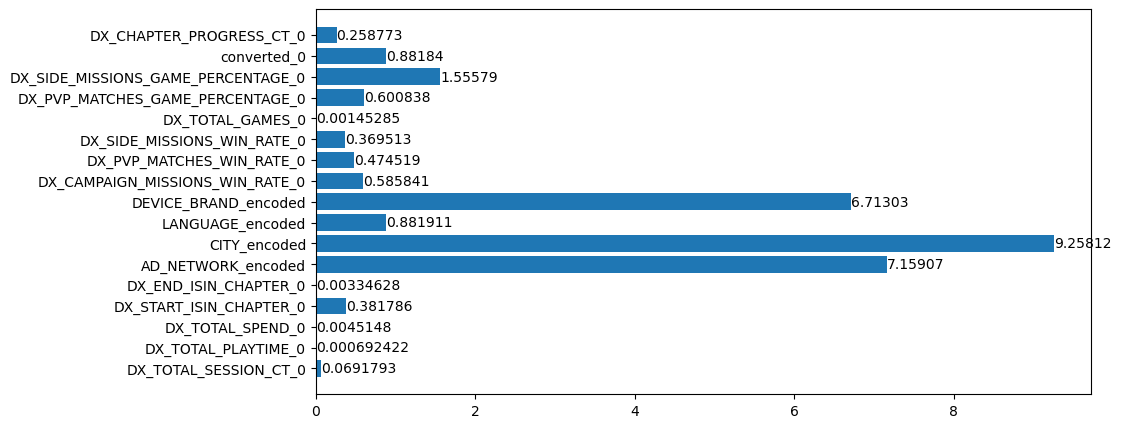

In [55]:
log_cls_model_00, _ = logistic_regression_retention_14(X_train = X_train_model_00,
                                                    X_test = X_test_model_00,
                                                    X_submitted = X_submitted_model_00)

### Day 1 Data

y_train has 94.63% of negative cases. The model will treat observation at 94.0+ percentile as positive.

Score Cutoff from 10-fold CV:
[0.2638, 0.258, 0.2586, 0.2636, 0.2629]
Mean of Score Cutoff: 26.14%

Accuracy using 10-fold CV:
[0.9421, 0.9414, 0.9427, 0.9414, 0.9425]
[0.9412, 0.9416, 0.9386, 0.9442, 0.9417]
[0.9335, 0.9338, 0.9329, 0.9338, 0.9342]
Mean of accuracy using 10-fold CV: 0.942 and 0.9415 and 0.9336

Precision using 10-fold CV:
[0.4655, 0.4596, 0.4694, 0.459, 0.4681]
[0.4553, 0.4621, 0.4386, 0.4829, 0.4601]
[0.3805, 0.385, 0.3778, 0.3834, 0.3853]
Mean of precision using 10-fold CV: 0.4643 and 0.4598 and 0.3824

Recall using 10-fold CV:
[0.52, 0.5135, 0.5247, 0.5131, 0.5233]
[0.4898, 0.551, 0.5087, 0.5349, 0.4855]
[0.3823, 0.3939, 0.3893, 0.3869, 0.38]
Mean of recall using 10-fold CV: 0.5189 and 0.514 and 0.3865

KS using 10-fold CV:
[0.694, 0.6853, 0.685, 0.6849, 0.6907]
[0.667, 0.6976, 0.6972, 0.7037, 0.6696]
[0.6483, 0.6469, 0.6507, 0.6485, 0.6502]
Mean of KS using 10-

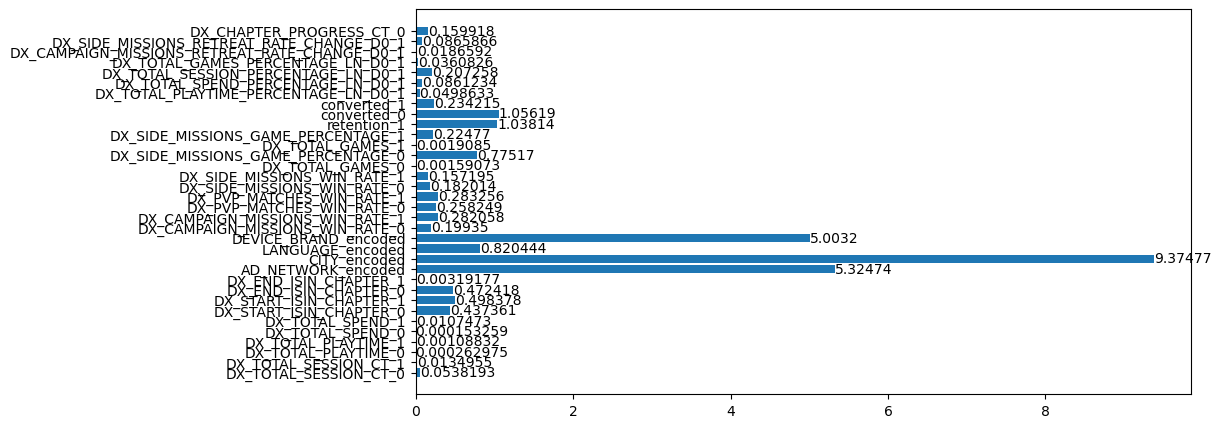

In [56]:
log_cls_model_01, _ = logistic_regression_retention_14(X_train = X_train_model_01,
                                                    X_test = X_test_model_01,
                                                    X_submitted = X_submitted_model_01)

### Day 3 Data

y_train has 94.63% of negative cases. The model will treat observation at 94.0+ percentile as positive.

Score Cutoff from 10-fold CV:
[0.3084, 0.3107, 0.3051, 0.3037, 0.3056]
Mean of Score Cutoff: 30.67%

Accuracy using 10-fold CV:
[0.9513, 0.952, 0.9525, 0.9522, 0.9523]
[0.9511, 0.9527, 0.9514, 0.948, 0.9514]
[0.9421, 0.9418, 0.9425, 0.9416, 0.9422]
Mean of accuracy using 10-fold CV: 0.9521 and 0.9509 and 0.942

Precision using 10-fold CV:
[0.5417, 0.5475, 0.5514, 0.5488, 0.5501]
[0.5373, 0.5532, 0.5438, 0.513, 0.5476]
[0.4629, 0.459, 0.4659, 0.4594, 0.4633]
Mean of precision using 10-fold CV: 0.5479 and 0.539 and 0.4621

Recall using 10-fold CV:
[0.6051, 0.6116, 0.6164, 0.6135, 0.615]
[0.6297, 0.6064, 0.5959, 0.6308, 0.5523]
[0.4942, 0.4825, 0.4942, 0.5012, 0.4848]
Mean of recall using 10-fold CV: 0.6123 and 0.603 and 0.4914

KS using 10-fold CV:
[0.7491, 0.7424, 0.7417, 0.7414, 0.74]
[0.7337, 0.7441, 0.744, 0.7451, 0.7475]
[0.7032, 0.7011, 0.702, 0.6981, 0.7008]
Mean of KS using 10

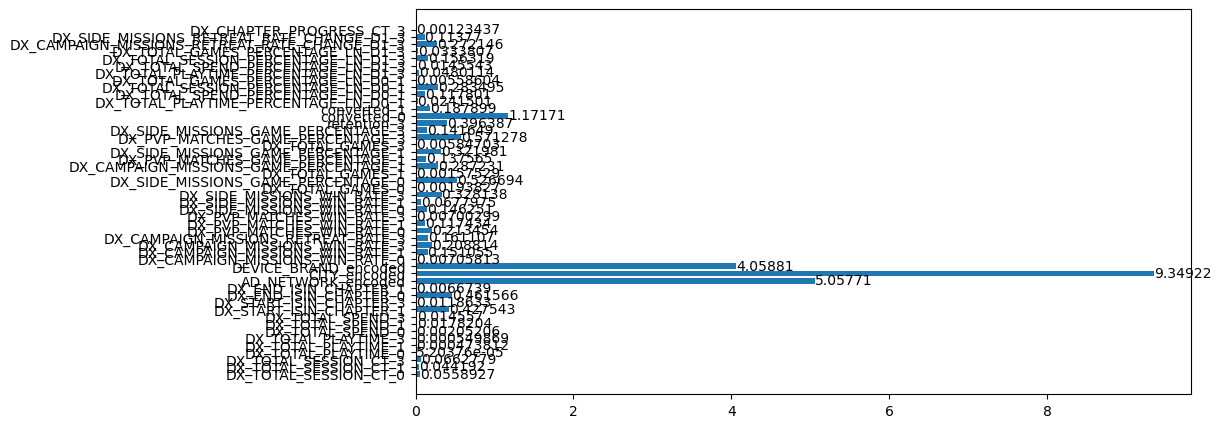

In [57]:
log_cls_model_03, _ = logistic_regression_retention_14(X_train = X_train_model_03,
                                                    X_test = X_test_model_03,
                                                    X_submitted = X_submitted_model_03)

### Day 7 Data

y_train has 94.63% of negative cases. The model will treat observation at 94.0+ percentile as positive.

Score Cutoff from 10-fold CV:
[0.3186, 0.3221, 0.3148, 0.3221, 0.3199]
Mean of Score Cutoff: 31.95%

Accuracy using 10-fold CV:
[0.9636, 0.9635, 0.9633, 0.9634, 0.9642]
[0.9623, 0.9633, 0.9642, 0.962, 0.9622]
[0.9556, 0.9551, 0.9545, 0.9548, 0.9545]
Mean of accuracy using 10-fold CV: 0.9636 and 0.9628 and 0.9549

Precision using 10-fold CV:
[0.6439, 0.6432, 0.6413, 0.6426, 0.6491]
[0.6349, 0.6444, 0.6501, 0.6205, 0.6386]
[0.5794, 0.5768, 0.5699, 0.5708, 0.5699]
Mean of precision using 10-fold CV: 0.644 and 0.6377 and 0.5734

Recall using 10-fold CV:
[0.7193, 0.7185, 0.7169, 0.7183, 0.7256]
[0.6997, 0.7026, 0.7238, 0.7558, 0.6831]
[0.6294, 0.6131, 0.6177, 0.6294, 0.6177]
Mean of recall using 10-fold CV: 0.7197 and 0.713 and 0.6215

KS using 10-fold CV:
[0.7944, 0.7976, 0.7929, 0.7941, 0.7939]
[0.7952, 0.7835, 0.7946, 0.7964, 0.7951]
[0.7544, 0.7532, 0.7508, 0.7472, 0.7492]
Mean of KS

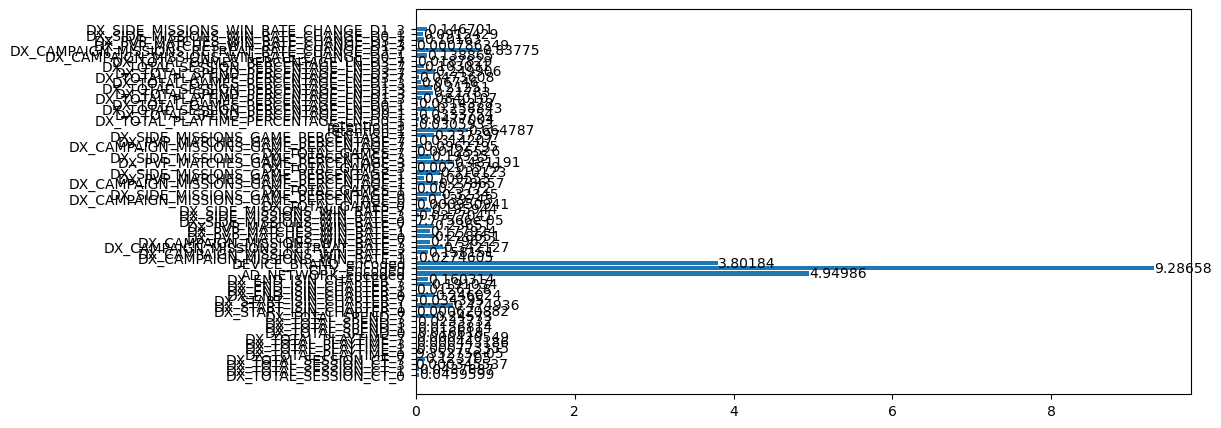

In [58]:
log_cls_model_07, _ = logistic_regression_retention_14(X_train = X_train_model_07,
                                                    X_test = X_test_model_07,
                                                    X_submitted = X_submitted_model_07)

## Random Forest

In [59]:
def random_forest_retention_14(X_train = X_train_model_07,
                               X_test = X_test_model_07,
                               X_submitted = X_submitted_model_07,
                               model = RandomForestClassifier(min_samples_leaf = 20, max_depth=3, min_impurity_decrease=0.002, random_state=42)):

    ###############################################################
    # Model
    ###############################################################

    rf_cls_model = classification_model_with_auc(X_cls = X_train,
                                                  X_test = X_test,
                                                  X_submitted = X_submitted,
                                                  model = model)

    ###############################################################
    # Feature Importance
    ###############################################################

    importance = rf_cls_model.feature_importances_
    colname = []
    importance_list = []

    # summarize feature importance
    for i, v in enumerate(zip(list(X_train.columns), importance)):
        if v[1] != 0:
            print('Feature {}: {}, Score: {:.3%}'.format(i, v[0], v[1]))
            colname.append(v[0])
            importance_list.append(v[1])

    # plot feature importance
    fig, ax = plt.subplots(figsize=(10, 5))
    fig.set_dpi(100)
    bars = ax.barh(colname, importance_list)
    ax.bar_label(bars)
    plt.show()

    return rf_cls_model

### Day 0 Data

y_train has 94.63% of negative cases. The model will treat observation at 94.0+ percentile as positive.

Score Cutoff from 10-fold CV:
[0.2184, 0.223, 0.213, 0.2155, 0.2107]
Mean of Score Cutoff: 21.61%

Accuracy using 10-fold CV:
[0.9258, 0.9245, 0.926, 0.9239, 0.9255]
[0.9264, 0.9225, 0.9219, 0.9277, 0.9245]
[0.9262, 0.9255, 0.9262, 0.9249, 0.9258]
Mean of accuracy using 10-fold CV: 0.9251 and 0.9246 and 0.9257

Precision using 10-fold CV:
[0.3297, 0.3225, 0.3329, 0.3168, 0.3308]
[0.327, 0.3053, 0.3098, 0.3486, 0.3258]
[0.3223, 0.3227, 0.3276, 0.3178, 0.3233]
Mean of precision using 10-fold CV: 0.3265 and 0.3233 and 0.3227

Recall using 10-fold CV:
[0.3695, 0.3695, 0.3777, 0.3617, 0.3785]
[0.3528, 0.3499, 0.3692, 0.3983, 0.3779]
[0.3403, 0.3543, 0.3566, 0.3497, 0.352]
Mean of recall using 10-fold CV: 0.3714 and 0.3696 and 0.3506

KS using 10-fold CV:
[0.5662, 0.5597, 0.5697, 0.5614, 0.5643]
[0.5514, 0.5804, 0.5567, 0.588, 0.5593]
[0.5271, 0.5326, 0.5313, 0.5304, 0.5245]
Mean of KS us

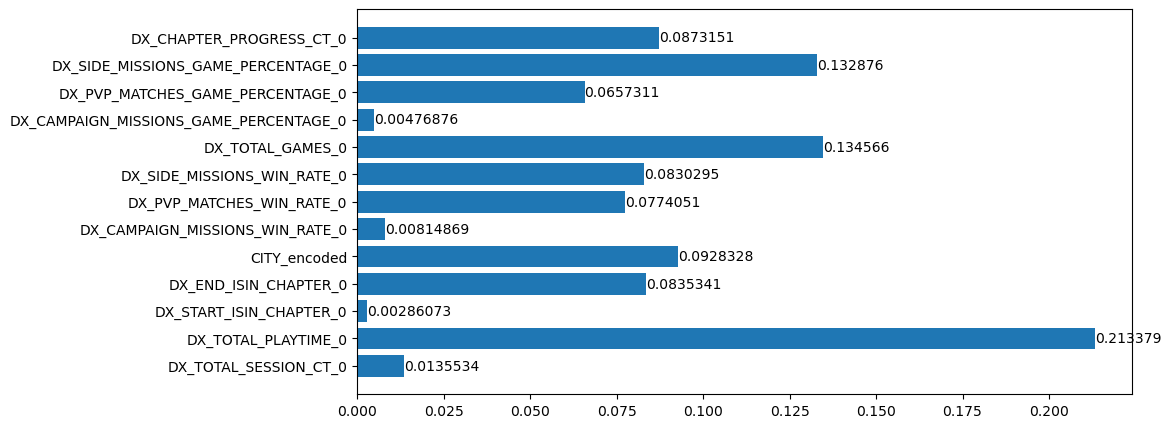

In [60]:
rf_cls_model_00 = random_forest_retention_14(X_train = X_train_model_00,
                                             X_test = X_test_model_00,
                                             X_submitted = X_submitted_model_00)

### Day 1 Data

y_train has 94.63% of negative cases. The model will treat observation at 94.0+ percentile as positive.

Score Cutoff from 10-fold CV:
[0.2804, 0.2766, 0.2766, 0.2845, 0.2792]
Mean of Score Cutoff: 27.95%

Accuracy using 10-fold CV:
[0.9361, 0.9354, 0.9358, 0.9361, 0.9359]
[0.9353, 0.9362, 0.9367, 0.9298, 0.9375]
[0.9354, 0.9362, 0.9362, 0.9349, 0.9355]
Mean of accuracy using 10-fold CV: 0.9359 and 0.9351 and 0.9356

Precision using 10-fold CV:
[0.4148, 0.4095, 0.4121, 0.4147, 0.4128]
[0.4043, 0.4173, 0.4208, 0.3704, 0.4243]
[0.4, 0.4121, 0.4082, 0.4, 0.4027]
Mean of precision using 10-fold CV: 0.4128 and 0.4074 and 0.4046

Recall using 10-fold CV:
[0.464, 0.4575, 0.4607, 0.4636, 0.4614]
[0.4373, 0.4781, 0.4709, 0.436, 0.4564]
[0.4103, 0.4429, 0.4196, 0.4289, 0.4196]
Mean of recall using 10-fold CV: 0.4614 and 0.4557 and 0.4243

KS using 10-fold CV:
[0.6543, 0.6487, 0.6458, 0.6458, 0.6567]
[0.6313, 0.6474, 0.6746, 0.6826, 0.6295]
[0.6464, 0.6481, 0.6503, 0.6444, 0.6471]
Mean of KS usin

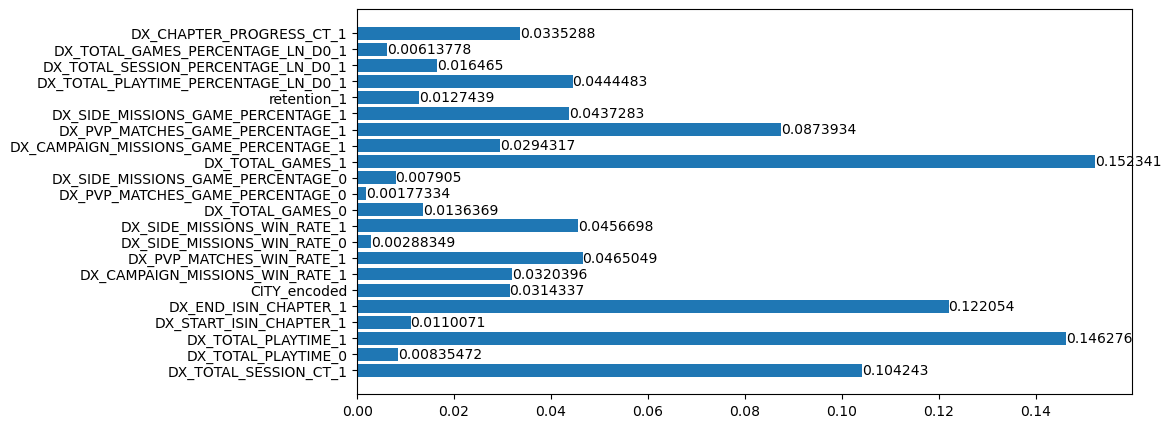

In [61]:
rf_cls_model_01 = random_forest_retention_14(X_train = X_train_model_01,
                                             X_test = X_test_model_01,
                                             X_submitted = X_submitted_model_01)

### Day 3 Data

y_train has 94.63% of negative cases. The model will treat observation at 94.0+ percentile as positive.

Score Cutoff from 10-fold CV:
[0.337, 0.3385, 0.3345, 0.3345, 0.3289]
Mean of Score Cutoff: 33.47%

Accuracy using 10-fold CV:
[0.9477, 0.9476, 0.9475, 0.9466, 0.9473]
[0.9431, 0.9478, 0.9467, 0.9448, 0.9492]
[0.9452, 0.9452, 0.9452, 0.9448, 0.9456]
Mean of accuracy using 10-fold CV: 0.9473 and 0.9463 and 0.9452

Precision using 10-fold CV:
[0.5117, 0.5111, 0.5098, 0.502, 0.5078]
[0.4727, 0.5119, 0.5039, 0.4891, 0.5274]
[0.4901, 0.4898, 0.4901, 0.4857, 0.4932]
Mean of precision using 10-fold CV: 0.5085 and 0.501 and 0.4898

Recall using 10-fold CV:
[0.5716, 0.5709, 0.5699, 0.5611, 0.5677]
[0.5306, 0.5656, 0.564, 0.5843, 0.532]
[0.5175, 0.5058, 0.5175, 0.5152, 0.5082]
Mean of recall using 10-fold CV: 0.5682 and 0.5553 and 0.5128

KS using 10-fold CV:
[0.71, 0.7214, 0.7194, 0.7072, 0.7105]
[0.6998, 0.7038, 0.7208, 0.7217, 0.7229]
[0.7068, 0.7059, 0.7034, 0.7028, 0.7057]
Mean of KS usi

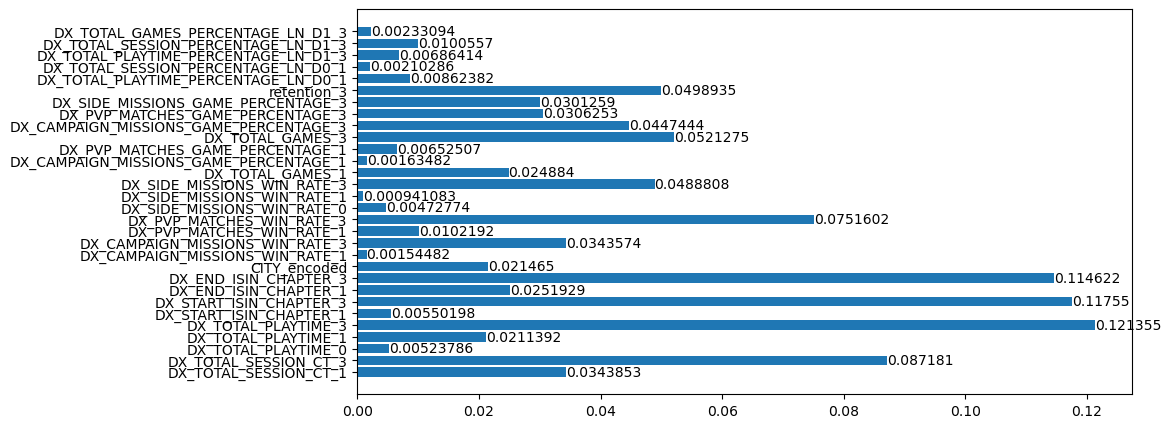

In [62]:
rf_cls_model_03 = random_forest_retention_14(X_train = X_train_model_03,
                                             X_test = X_test_model_03,
                                             X_submitted = X_submitted_model_03)

### Day 7 Data

y_train has 94.63% of negative cases. The model will treat observation at 94.0+ percentile as positive.

Score Cutoff from 10-fold CV:
[0.3729, 0.3632, 0.3572, 0.3557, 0.3676]
Mean of Score Cutoff: 36.33%

Accuracy using 10-fold CV:
[0.9598, 0.9594, 0.9594, 0.959, 0.9598]
[0.958, 0.9603, 0.9594, 0.9608, 0.9584]
[0.9571, 0.9572, 0.9574, 0.9569, 0.9574]
Mean of accuracy using 10-fold CV: 0.9595 and 0.9594 and 0.9572

Precision using 10-fold CV:
[0.6126, 0.6094, 0.6087, 0.6055, 0.6126]
[0.5995, 0.6226, 0.6099, 0.6148, 0.5995]
[0.5935, 0.5948, 0.5961, 0.589, 0.5944]
Mean of precision using 10-fold CV: 0.6098 and 0.6093 and 0.5936

Recall using 10-fold CV:
[0.6844, 0.6807, 0.6805, 0.6769, 0.6849]
[0.6501, 0.6589, 0.6773, 0.7238, 0.6831]
[0.6364, 0.6364, 0.6364, 0.648, 0.6457]
Mean of recall using 10-fold CV: 0.6815 and 0.6786 and 0.6406

KS using 10-fold CV:
[0.7669, 0.7746, 0.7691, 0.7645, 0.7722]
[0.7768, 0.7575, 0.766, 0.7821, 0.7688]
[0.7627, 0.7633, 0.7592, 0.7621, 0.763]
Mean of KS us

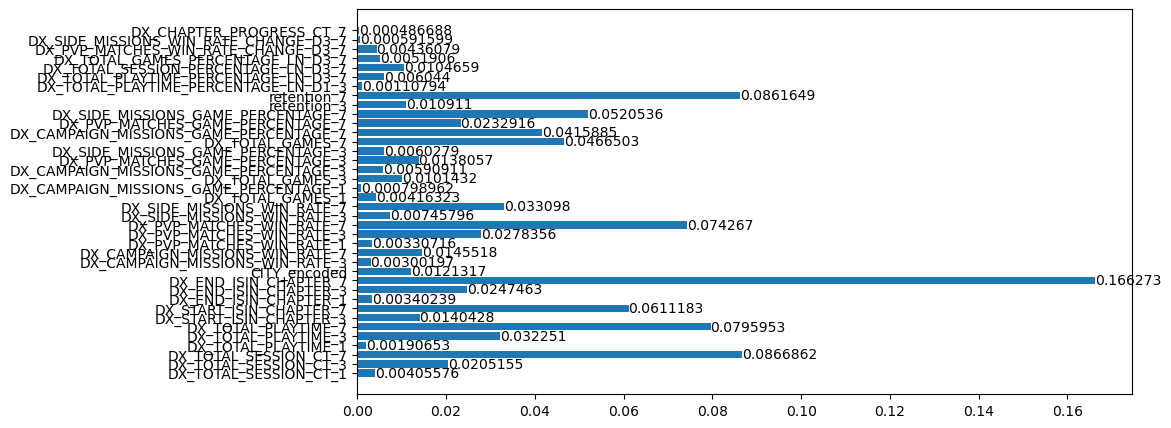

In [63]:
rf_cls_model_07 = random_forest_retention_14(X_train = X_train_model_07,
                                             X_test = X_test_model_07,
                                             X_submitted = X_submitted_model_07)

## Gradient Boosting

In [64]:
def gradient_boosting_retention_14(X_train = X_train_model_07,
                               X_test = X_test_model_07,
                               X_submitted = X_submitted_model_07,
                               model = GradientBoostingClassifier(min_samples_leaf=500, max_depth=2, n_estimators=10, min_impurity_decrease=0.002, random_state=42)):

    ###############################################################
    # Model
    ###############################################################

    gb_cls_model = classification_model_with_auc(X_cls = X_train,
                                                  X_test = X_test,
                                                  X_submitted = X_submitted,
                                                  model = model)

    ###############################################################
    # Feature Importance
    ###############################################################

    importance = gb_cls_model.feature_importances_
    colname = []
    importance_list = []

    # summarize feature importance
    for i, v in enumerate(zip(list(X_train.columns), importance)):
        if v[1] != 0:
            print('Feature {}: {}, Score: {:.3%}'.format(i, v[0], v[1]))
            colname.append(v[0])
            importance_list.append(v[1])

    # plot feature importance
    fig, ax = plt.subplots(figsize=(10, 5))
    fig.set_dpi(100)
    bars = ax.barh(colname, importance_list)
    ax.bar_label(bars)
    plt.show()

    return gb_cls_model

### Day 0 Data

y_train has 94.63% of negative cases. The model will treat observation at 94.0+ percentile as positive.

Score Cutoff from 10-fold CV:
[0.1696, 0.1687, 0.1723, 0.1815, 0.1496]
Mean of Score Cutoff: 16.83%

Accuracy using 10-fold CV:
[0.931, 0.9332, 0.9336, 0.9306, 0.9311]
[0.9327, 0.9311, 0.9291, 0.9319, 0.9288]
[0.9231, 0.9232, 0.9234, 0.923, 0.9212]
Mean of accuracy using 10-fold CV: 0.9319 and 0.9307 and 0.9228

Precision using 10-fold CV:
[0.3809, 0.3918, 0.3975, 0.3768, 0.3834]
[0.3842, 0.3763, 0.3625, 0.3889, 0.371]
[0.3062, 0.3028, 0.3091, 0.3103, 0.2994]
Mean of precision using 10-fold CV: 0.3861 and 0.3766 and 0.3056

Recall using 10-fold CV:
[0.4545, 0.44, 0.4614, 0.4476, 0.4665]
[0.4257, 0.4344, 0.4215, 0.468, 0.468]
[0.3427, 0.331, 0.3473, 0.3566, 0.3497]
Mean of recall using 10-fold CV: 0.454 and 0.4435 and 0.3455

KS using 10-fold CV:
[0.5806, 0.5776, 0.5945, 0.5859, 0.5855]
[0.5667, 0.6151, 0.5825, 0.6243, 0.5675]
[0.5246, 0.5313, 0.5196, 0.5149, 0.5226]
Mean of KS using

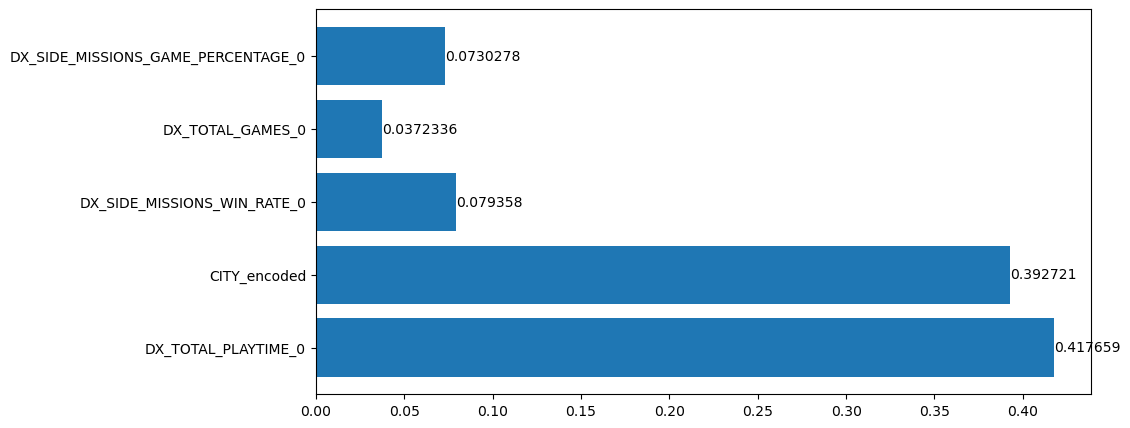

In [65]:
gb_cls_model_00 = gradient_boosting_retention_14(X_train = X_train_model_00,
                                             X_test = X_test_model_00,
                                             X_submitted = X_submitted_model_00)

### Day 1 Data

y_train has 94.63% of negative cases. The model will treat observation at 94.0+ percentile as positive.

Score Cutoff from 10-fold CV:
[0.2209, 0.234, 0.2033, 0.2388, 0.2277]
Mean of Score Cutoff: 22.49%

Accuracy using 10-fold CV:
[0.9419, 0.9401, 0.941, 0.9405, 0.9411]
[0.9383, 0.9383, 0.9384, 0.9359, 0.9423]
[0.936, 0.9349, 0.9351, 0.935, 0.9358]
Mean of accuracy using 10-fold CV: 0.9409 and 0.9386 and 0.9354

Precision using 10-fold CV:
[0.4642, 0.4494, 0.4558, 0.4526, 0.4568]
[0.4319, 0.4353, 0.4372, 0.4179, 0.4675]
[0.4076, 0.4, 0.3996, 0.4013, 0.4062]
Mean of precision using 10-fold CV: 0.4558 and 0.438 and 0.4029

Recall using 10-fold CV:
[0.5287, 0.5098, 0.5109, 0.5182, 0.5153]
[0.481, 0.5102, 0.5058, 0.4884, 0.5233]
[0.4266, 0.4289, 0.4172, 0.4312, 0.4289]
Mean of recall using 10-fold CV: 0.5166 and 0.5017 and 0.4266

KS using 10-fold CV:
[0.6767, 0.6663, 0.6647, 0.6616, 0.6736]
[0.65, 0.6724, 0.6818, 0.6953, 0.6436]
[0.6392, 0.6305, 0.6316, 0.6355, 0.6302]
Mean of KS using 1

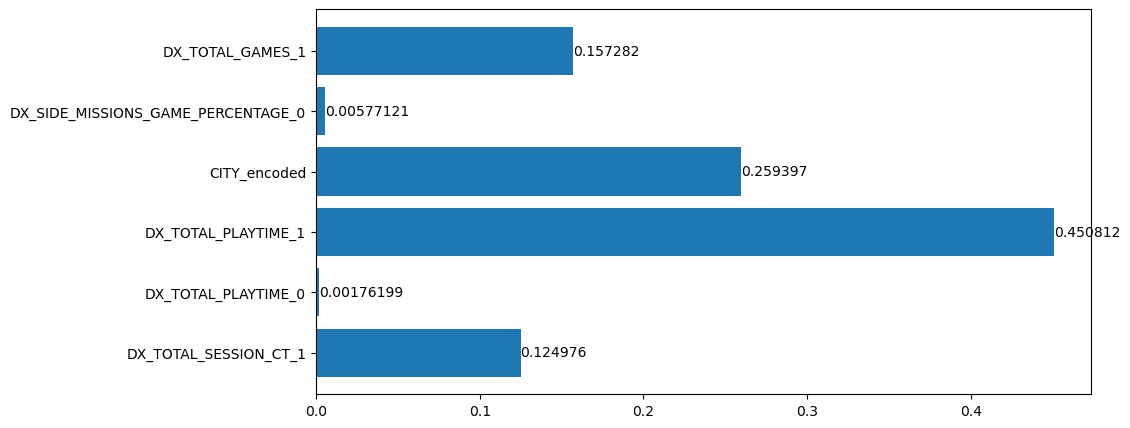

In [66]:
gb_cls_model_01 = gradient_boosting_retention_14(X_train = X_train_model_01,
                                             X_test = X_test_model_01,
                                             X_submitted = X_submitted_model_01)

### Day 3 Data

y_train has 94.63% of negative cases. The model will treat observation at 94.0+ percentile as positive.

Score Cutoff from 10-fold CV:
[0.2243, 0.2146, 0.2032, 0.2135, 0.2026]
Mean of Score Cutoff: 21.16%

Accuracy using 10-fold CV:
[0.9502, 0.9503, 0.9511, 0.9507, 0.9507]
[0.9475, 0.9494, 0.948, 0.9477, 0.9523]
[0.9468, 0.9458, 0.9448, 0.9458, 0.9454]
Mean of accuracy using 10-fold CV: 0.9506 and 0.949 and 0.9457

Precision using 10-fold CV:
[0.5323, 0.5329, 0.5392, 0.5365, 0.5368]
[0.509, 0.5241, 0.5145, 0.5111, 0.5531]
[0.5034, 0.4944, 0.4851, 0.4945, 0.491]
Mean of precision using 10-fold CV: 0.5355 and 0.5224 and 0.4937

Recall using 10-fold CV:
[0.6, 0.6065, 0.6063, 0.5997, 0.6004]
[0.5773, 0.6035, 0.5669, 0.6017, 0.5901]
[0.5128, 0.5152, 0.4942, 0.5268, 0.5105]
Mean of recall using 10-fold CV: 0.6026 and 0.5879 and 0.5119

KS using 10-fold CV:
[0.7234, 0.7192, 0.719, 0.7195, 0.7178]
[0.7161, 0.7088, 0.7121, 0.7265, 0.7227]
[0.6868, 0.6883, 0.6843, 0.683, 0.685]
Mean of KS using 

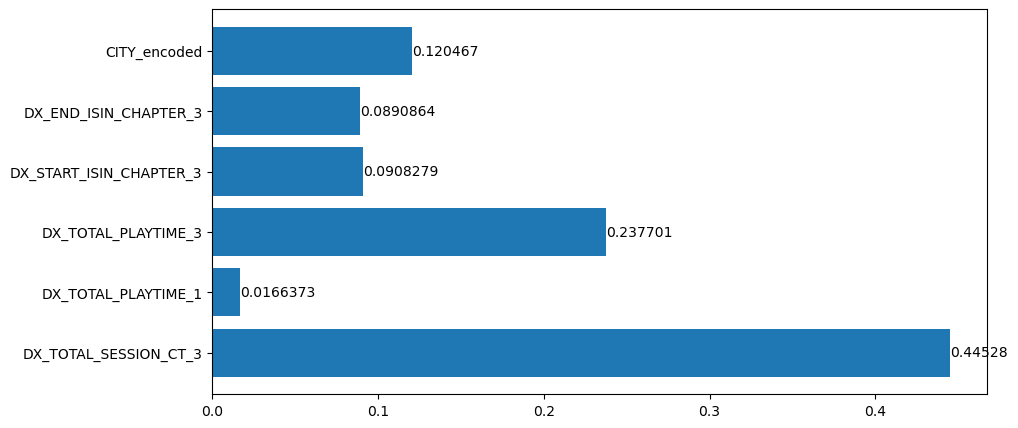

In [67]:
gb_cls_model_03 = gradient_boosting_retention_14(X_train = X_train_model_03,
                                             X_test = X_test_model_03,
                                             X_submitted = X_submitted_model_03)

### **Day 7 Data (This is our final model with F1 score from test set)**

y_train has 94.63% of negative cases. The model will treat observation at 94.0+ percentile as positive.

Score Cutoff from 10-fold CV:
[0.2217, 0.2416, 0.2125, 0.2184, 0.238]
Mean of Score Cutoff: 22.64%

Accuracy using 10-fold CV:
[0.9594, 0.9609, 0.9607, 0.9609, 0.9606]
[0.9595, 0.9612, 0.9609, 0.9598, 0.9591]
[0.9559, 0.957, 0.957, 0.9568, 0.9568]
Mean of accuracy using 10-fold CV: 0.9605 and 0.9601 and 0.9567

Precision using 10-fold CV:
[0.6045, 0.6201, 0.6158, 0.621, 0.6166]
[0.6088, 0.6301, 0.6181, 0.6028, 0.6035]
[0.5785, 0.5906, 0.5895, 0.5881, 0.5866]
Mean of precision using 10-fold CV: 0.6156 and 0.6127 and 0.5867

Recall using 10-fold CV:
[0.7047, 0.7004, 0.7103, 0.6965, 0.7045]
[0.6851, 0.6706, 0.7151, 0.7413, 0.6948]
[0.6527, 0.6457, 0.6527, 0.6457, 0.655]
Mean of recall using 10-fold CV: 0.7033 and 0.7014 and 0.6504

KS using 10-fold CV:
[0.779, 0.7749, 0.7803, 0.7717, 0.7778]
[0.7749, 0.7834, 0.7603, 0.7798, 0.7809]
[0.7614, 0.7542, 0.7532, 0.7414, 0.7416]
Mean of KS us

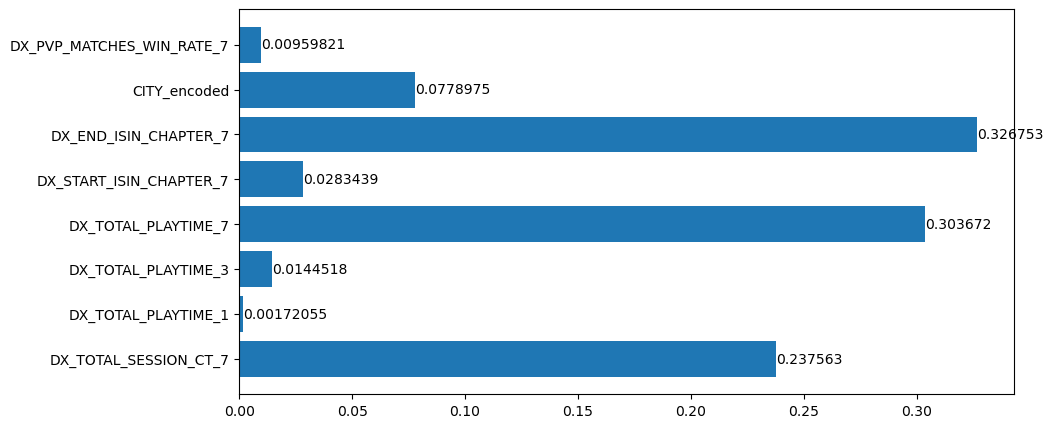

In [68]:
gb_cls_model_07 = gradient_boosting_retention_14(X_train = X_train_model_07,
                                             X_test = X_test_model_07,
                                             X_submitted = X_submitted_model_07)

# Predictions
For the sake of F1 score, gb_cls_model_07 was selected for prediction. It had 0.3% lower F1 score based on our own test set, but its features was way simpler.


Moving further, I might choose D0-D7 depends on how much cost and benefit of earlier prediction. Afterall, D0 had been visualized as where people churn the most.

In [69]:
def prediction(final_model = gb_cls_model_07,
               final_X_train = X_train_model_07, final_y_train = y_train,
               final_X_submitted = X_submitted_model_07):

    final_positive_case_percentage = (1 - final_y_train.mean())
    final_model_cutoff = np.percentile(final_model.predict_proba(final_X_train)[:,1], np.floor(100 * final_positive_case_percentage))

    print("y_train has {:.2%} of negative cases. The model will treat observation at {}+ percentile as positive.".format(final_positive_case_percentage,
                                                                                                                        np.floor(100*final_positive_case_percentage)))
    print("Cutoff probability for positive retention_14: {:.2%}\n".format(final_model_cutoff))

    final_y_prob = final_model.predict_proba(final_X_submitted)[:, 1]
    final_y_pred = (final_y_prob >= final_model_cutoff)

    return final_y_pred

X_submitted_prediction = prediction()
X_submitted_prediction

y_train has 94.63% of negative cases. The model will treat observation at 94.0+ percentile as positive.
Cutoff probability for positive retention_14: 23.12%



array([False, False, False, ..., False, False, False])

In [70]:
np.unique(gb_cls_model_07.predict_proba(X_submitted_model_07)[:, 1])

array([0.0265, 0.0302, 0.0310, 0.0317, 0.0353, 0.0374, 0.0437, 0.0438,
       0.0461, 0.0496, 0.0547, 0.0549, 0.0595, 0.0672, 0.0710, 0.0714,
       0.0803, 0.0865, 0.1000, 0.1072, 0.1124, 0.1202, 0.1207, 0.1249,
       0.1273, 0.1321, 0.1332, 0.1406, 0.1422, 0.1520, 0.1529, 0.1561,
       0.1691, 0.1717, 0.1784, 0.1788, 0.1802, 0.1987, 0.2007, 0.2064,
       0.2203, 0.2207, 0.2214, 0.2215, 0.2289, 0.2363, 0.2392, 0.2415,
       0.2509, 0.2533, 0.2557, 0.2692, 0.2696, 0.2721, 0.2761, 0.2892,
       0.2916, 0.3035, 0.3061, 0.3081, 0.3185, 0.3287, 0.3311, 0.3477,
       0.3495, 0.3524, 0.3588, 0.3657, 0.3700, 0.3785, 0.3834, 0.4117,
       0.4150, 0.4303, 0.4409, 0.4632, 0.4699, 0.4910, 0.5032, 0.5101,
       0.5244, 0.5444, 0.5775, 0.6097])

In [71]:
# I will read_csv again because I neither want to alter original dtype nor replace nan value
original_submitted_df = pd.read_csv('data/data_retention_submission.csv', dtype=object, keep_default_na=False)
original_submitted_df["pred_retention_14"] = X_submitted_prediction

original_submitted_df

,Player ID,AD_NETWORK,AD_CHANNEL,COUNTRY,CITY,LANGUAGE,DEVICE_BRAND,install_date,DX_TOTAL_SESSION_CT_0,DX_TOTAL_SESSION_CT_1,...,DX_START_ISIN_CHAPTER_1,DX_START_ISIN_CHAPTER_3,DX_START_ISIN_CHAPTER_7,DX_START_ISIN_CHAPTER_14,DX_END_ISIN_CHAPTER_0,DX_END_ISIN_CHAPTER_1,DX_END_ISIN_CHAPTER_3,DX_END_ISIN_CHAPTER_7,DX_END_ISIN_CHAPTER_14,pred_retention_14
0,Player40001,Organic,Organic,PH,Baguio City,English,vivo,2022-07-06,1.0,0.0,...,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,False
1,Player40002,Organic,Organic,NL,Sneek,Dutch,samsung,2022-08-30,1.0,0.0,...,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,False
2,Player40003,Adjoe,Paid,NL,Amsterdam,English,OPPO,2022-08-30,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
3,Player40004,Unattributed,Paid,DK,Olstykke,Danish,Lenovo,2022-07-20,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,False
4,Player40005,Unattributed,Paid,SG,Singapore,English,OnePlus,2022-07-29,2.0,0.0,...,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2291,Player42292,Unity,Paid,NL,Rotterdam,Dutch,samsung,2022-05-23,1.0,0.0,...,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,False
2292,Player42293,Unattributed,Paid,AU,Sydney,English,samsung,2022-03-23,1.0,0.0,...,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,False
2293,Player42294,Unattributed,Paid,PH,Davao City,English,realme,2022-02-09,3.0,0.0,...,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,False
2294,Player42295,Organic,Organic,PH,Quezon City,English,T-Mobile,2022-07-06,3.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,False


In [72]:
print(original_submitted_df["pred_retention_14"].mean(), end="\n\n")
original_submitted_df.groupby("pred_retention_14").size()

0.059233449477351915



pred_retention_14
False    2160
True      136
dtype: int64

In [73]:
# original_submitted_df.to_csv('data/data_retention_submission_Y.csv', index=False)

# Optimization: DX Retention vs F1 Improvement
This depends on the cost of retention and F1

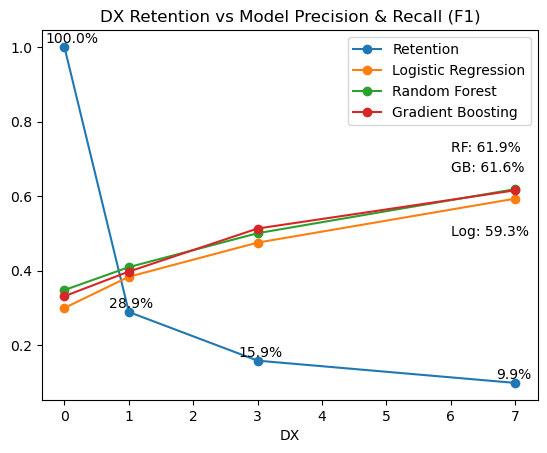

In [83]:
retention_graph_f1 = retention_graph[:-1].copy()

retention_graph_f1["Logistic Regression"] = pd.Series([0.30, 0.3837209302325582, 0.47533632286995514, 0.5932584269662922])
retention_graph_f1["Random Forest"] = pd.Series([0.34809474768280124, 0.4095022624434389, 0.5005636978579482, 0.6186726659167604])
retention_graph_f1["Gradient Boosting"] = pd.Series([0.3315954118873827, 0.3975903614457832, 0.5131004366812226, 0.6155555555555555])

retention_graph_f1.plot.line(x = "DX", y=["Retention", "Logistic Regression", "Random Forest", "Gradient Boosting"], marker ='o')

# Mark Label
for i, num in enumerate(retention_graph_f1["Retention"]):
    plt.annotate("{:.1%}".format(num), (retention_graph_f1["DX"][i]-0.3, num+0.01))

plt.annotate("RF: {:.1%}".format(retention_graph_f1["Random Forest"][3]), (retention_graph_f1["DX"][3]-1, retention_graph_f1["Random Forest"][3]+0.1))
plt.annotate("GB: {:.1%}".format(retention_graph_f1["Gradient Boosting"][3]), (retention_graph_f1["DX"][3]-1, retention_graph_f1["Gradient Boosting"][3]+0.05))
plt.annotate("Log: {:.1%}".format(retention_graph_f1["Logistic Regression"][3]), (retention_graph_f1["DX"][3]-1, retention_graph_f1["Logistic Regression"][3]-0.1))

plt.title("DX Retention vs Model Precision & Recall (F1)")
plt.show()